In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# A *real* Lightning Talk

Julia Signell, Hydrometeorology Group, Princeton University, SciPy 2016

<img src="http://www.ballardian.com/wp-content/uploads/lightning_field.jpg" width="90%"/>

## Dataset: NLDN
The National Lightning Detection Network maintained by Vaisala
   >"The National Lightning Detection Network, NLDN, consists of over 100 remote, ground-based sensing stations located across the United States that instantaneously detect the electromagnetic signals given off when lightning strikes the earth's surface. These remote sensors send the raw data via a satellite-based communications network to the Network Control Center operated by Vaisala Inc. in Tucson, Arizona. Within seconds of a lightning strike, the NCC's central analyzers process information on the location, time, polarity, and communicated to users across the country." (*[NASA](http://gcmd.nasa.gov/records/GCMD_NLDN.html)*)

## Objective: Use lightning to track storms with poor radar coverage

<img src="http://www.wdtb.noaa.gov/courses/MRMS/images/PrecipProductImages/RQI-ex2.png" width="90%"/>

<h2><center>Lightning is easy to measure, so we have it everywhere</center></h2>

## Tools: SpatialVx
To track storms we used [SpatialVx](https://www.ral.ucar.edu/projects/icp/SpatialVx/): an R package developed at UCAR. Feature identification and matching functions are called using Python and outputted to pandas

In [2]:
import pandas as pd
from pointprocess import *
from lightning_setup import *
from titan import *
from cartopy.io.img_tiles import StamenTerrain

%matplotlib inline

In [3]:
c = Region(city=cities['cedar'])
c.define_grid()
storm = '2010-07-20'

fname = '../../lightning/'+storm+'.txt'
df = read_TITAN(fname)

features = pd.HDFStore('cedar/features.h5')
p = features['features_1km5min_thresh01_sigma3_minarea4_const5_buffered_{storm}'.format(storm=storm)]
features.close()

ft = Features(p[df.index[0]:df.index[-1],:,:])
df_light = ft.titanize()

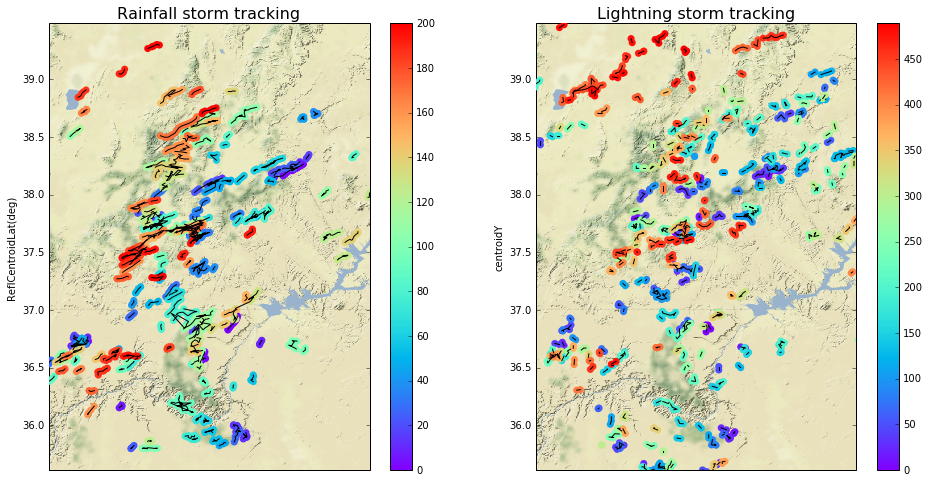

In [7]:
plt.figure(figsize=(16, 8))

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.add_image(StamenTerrain(), 8)
ax1 = feature_locations(df, lat='ReflCentroidLat(deg)', lon='ReflCentroidLon(deg)', ax=ax1, paths=True)
extent = ax1.get_extent()
ax1.set_title('Rainfall storm tracking', fontsize=16)

ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
ax2.add_image(StamenTerrain(), 8)
ax2 = feature_locations(df_light, lat='centroidY' ,lon='centroidX', paths=True, ax=ax2)
ax2.set_extent(extent)
ax2.set_title('Lightning storm tracking', fontsize=16);

In [5]:
# get grid slices for that day optionally filtering out cloud to cloud lightning
box, tr = c.get_daily_grid_slices(storm, filter_CG=(0,20), base=12)

# initialixe databox object
db = c.to_databox(box, tr[0:-1])


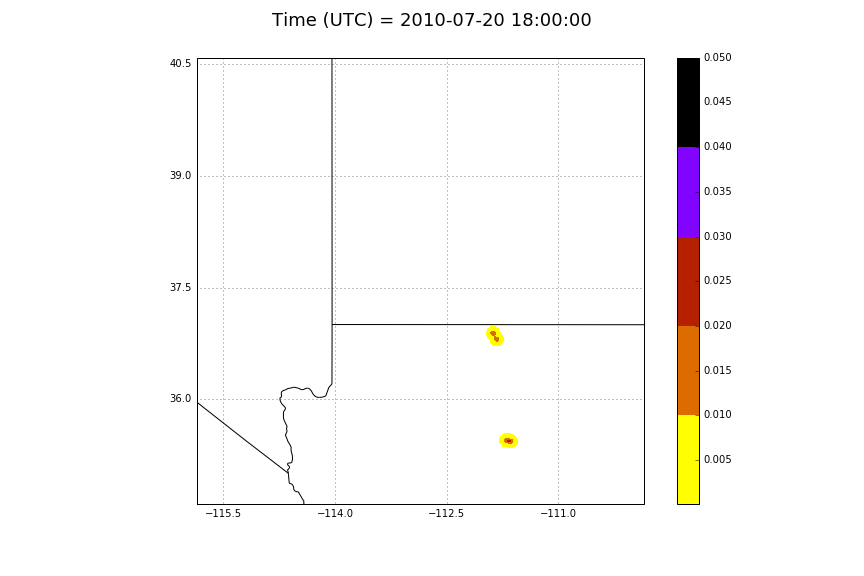
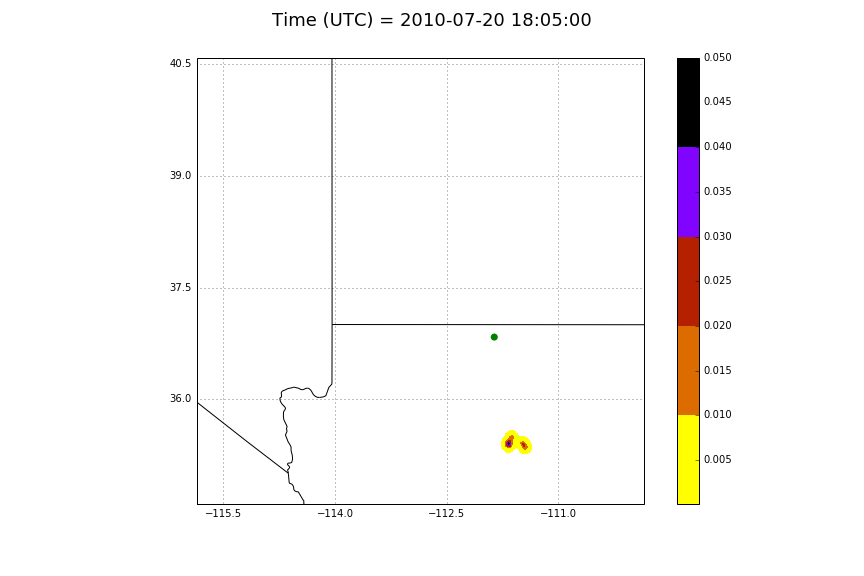
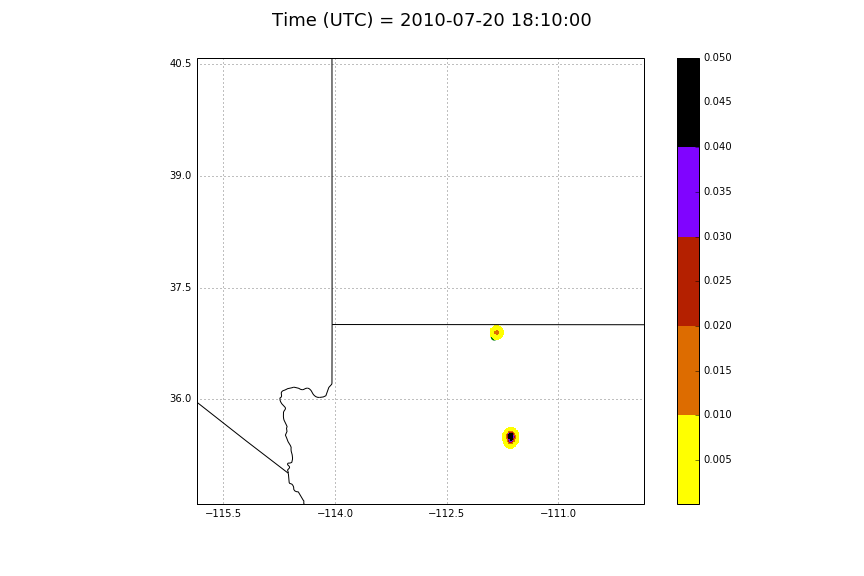
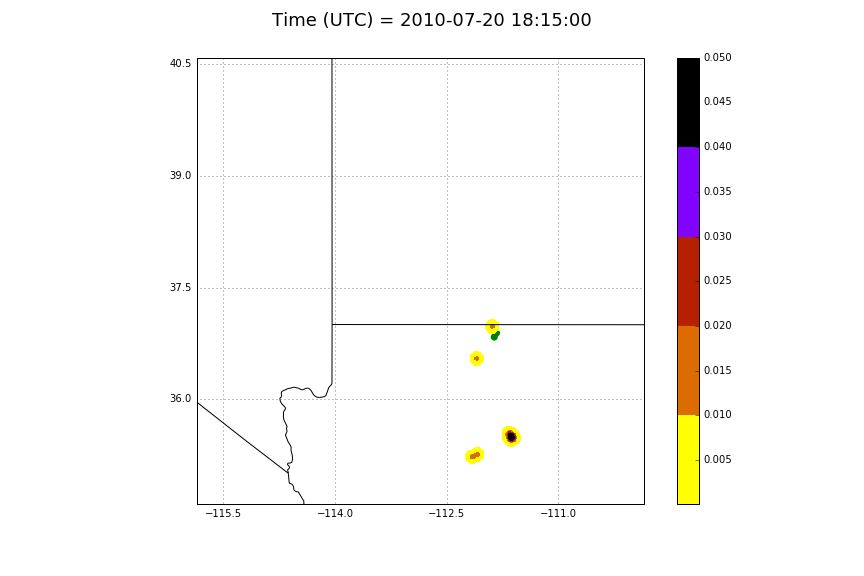
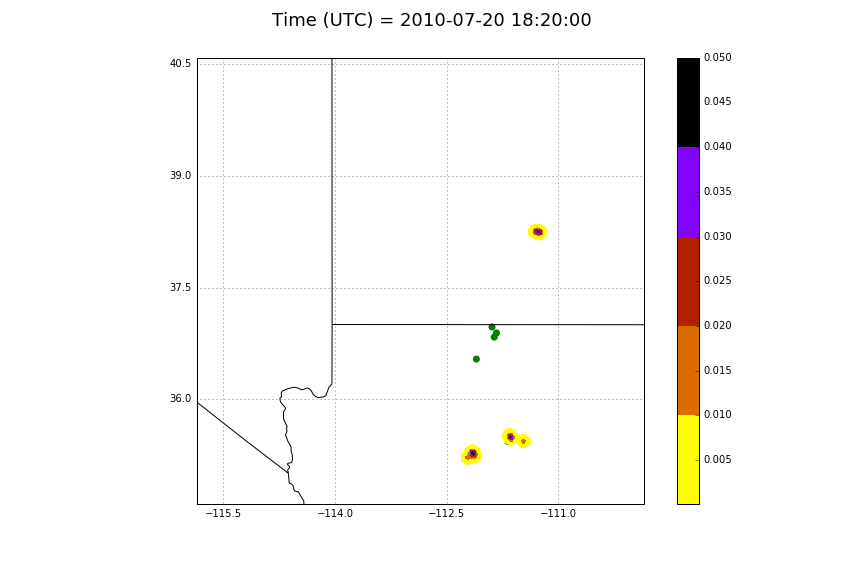
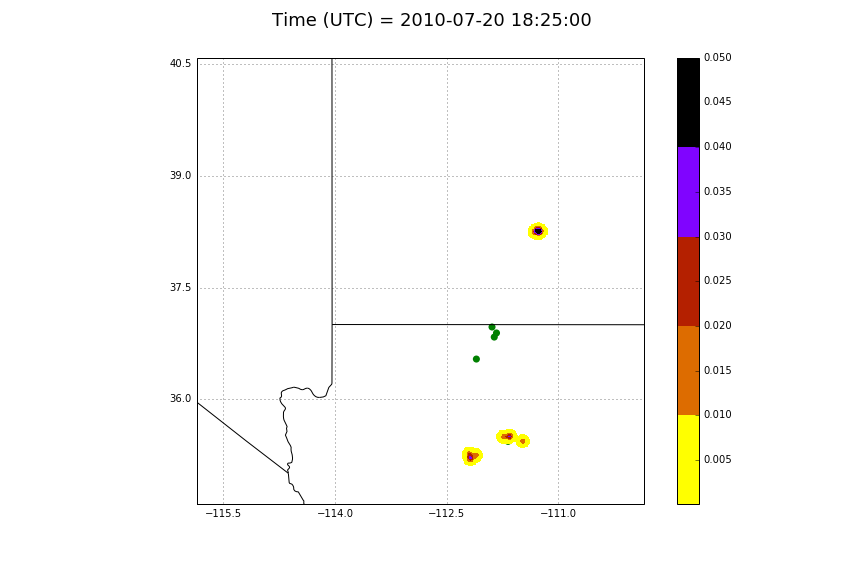
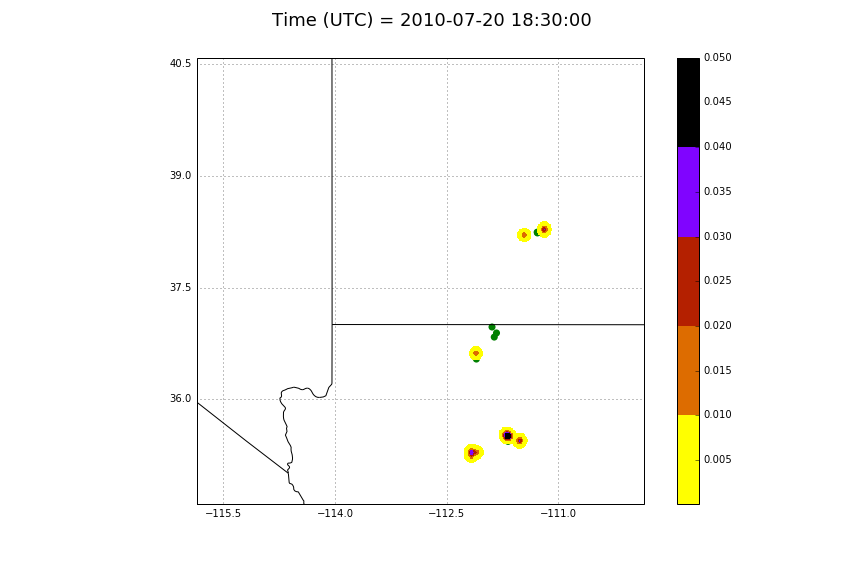
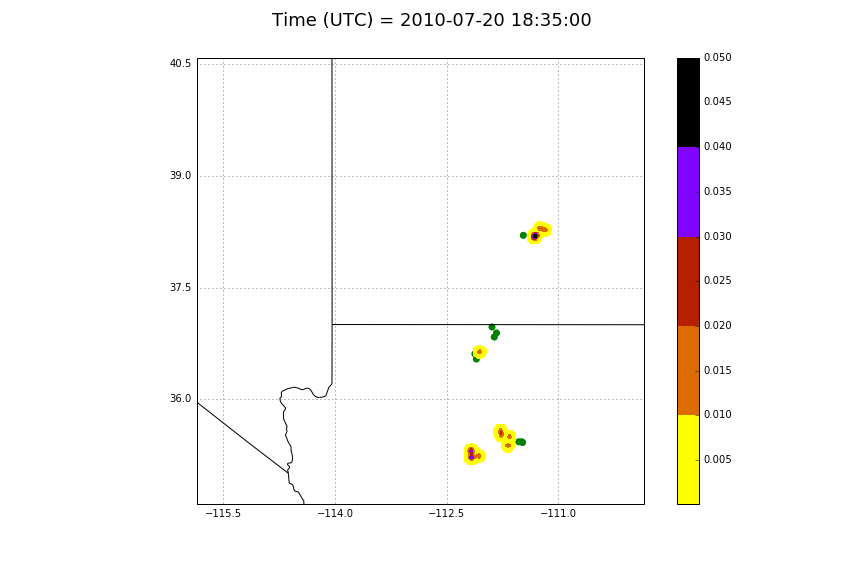
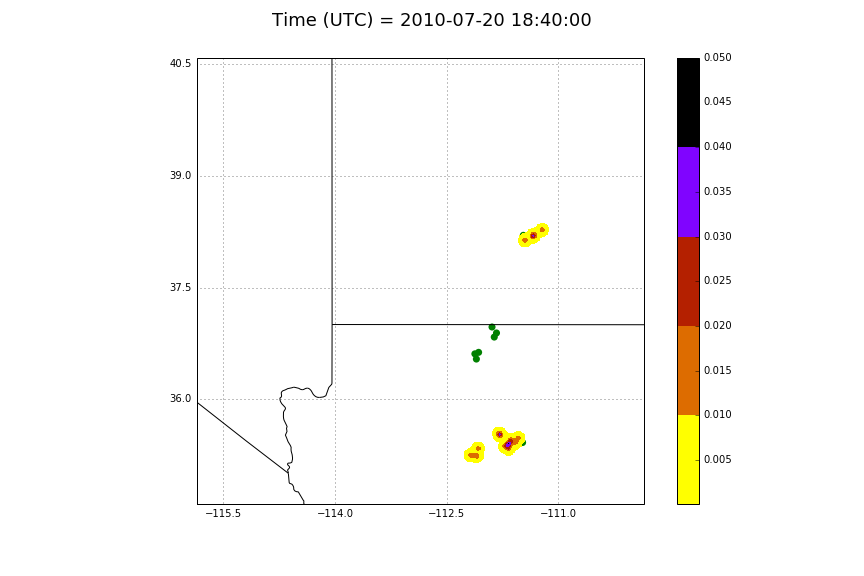
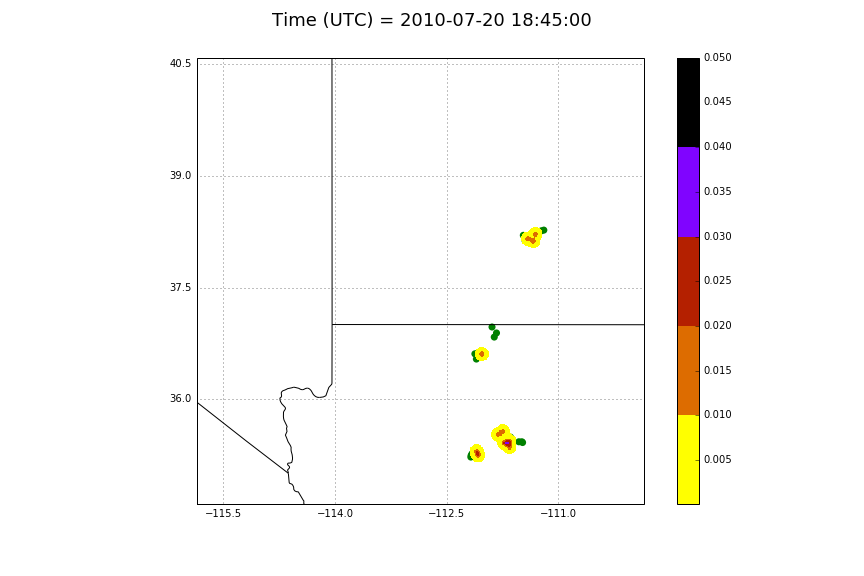
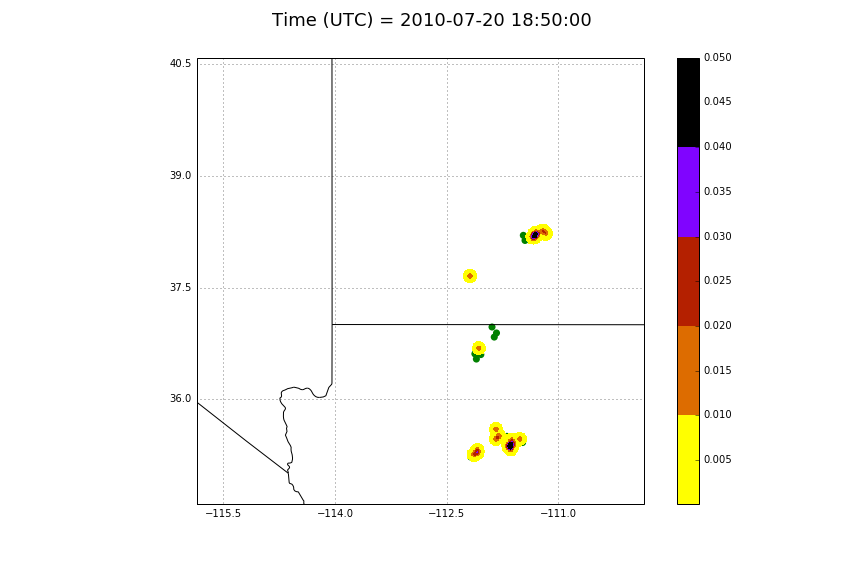
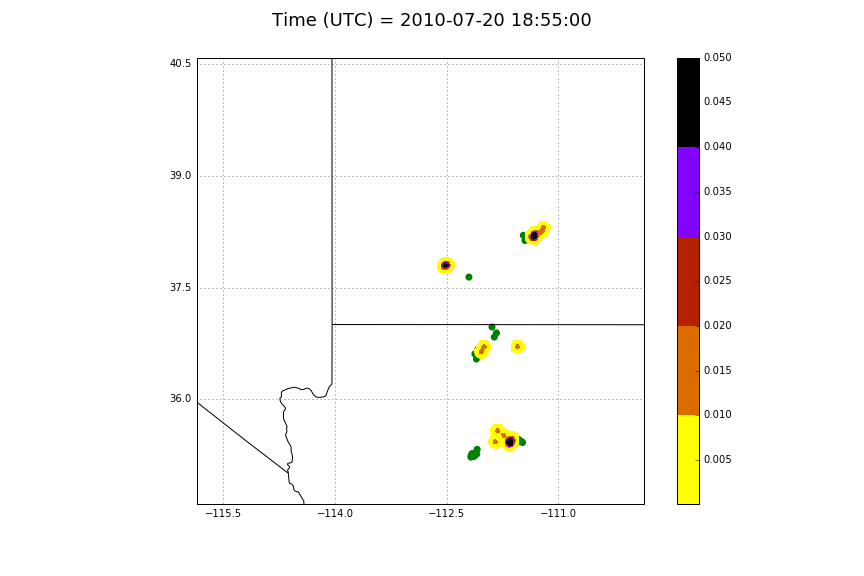
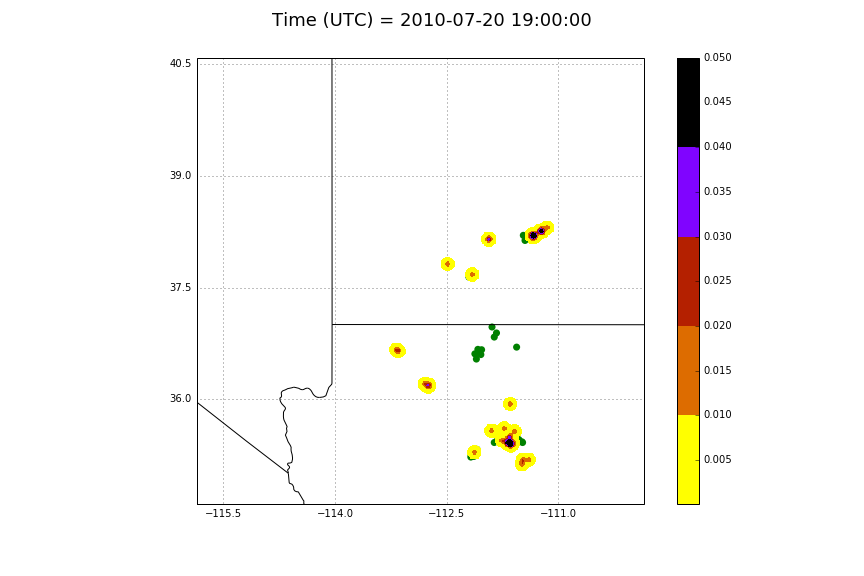
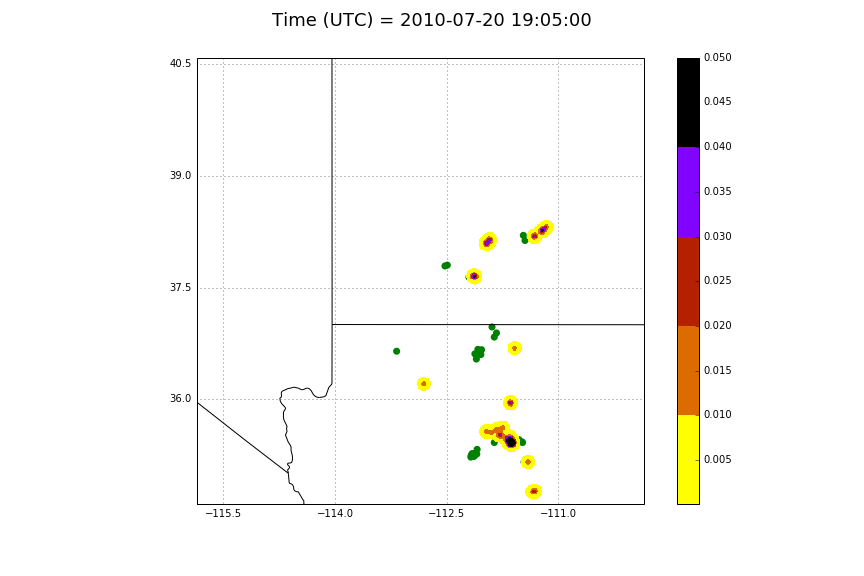
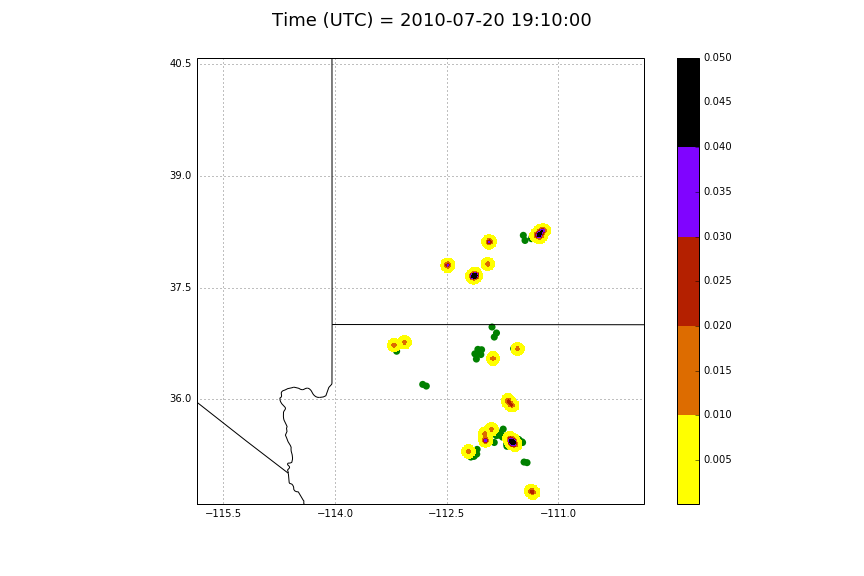
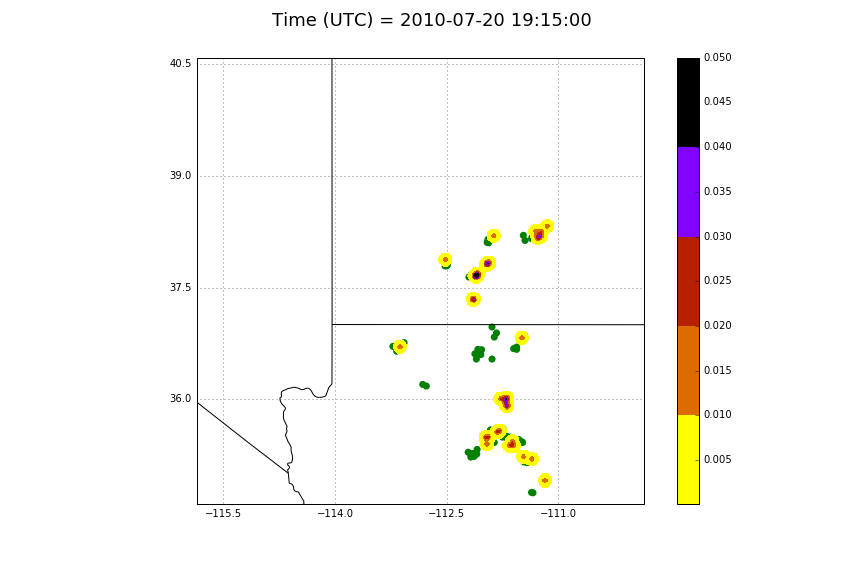
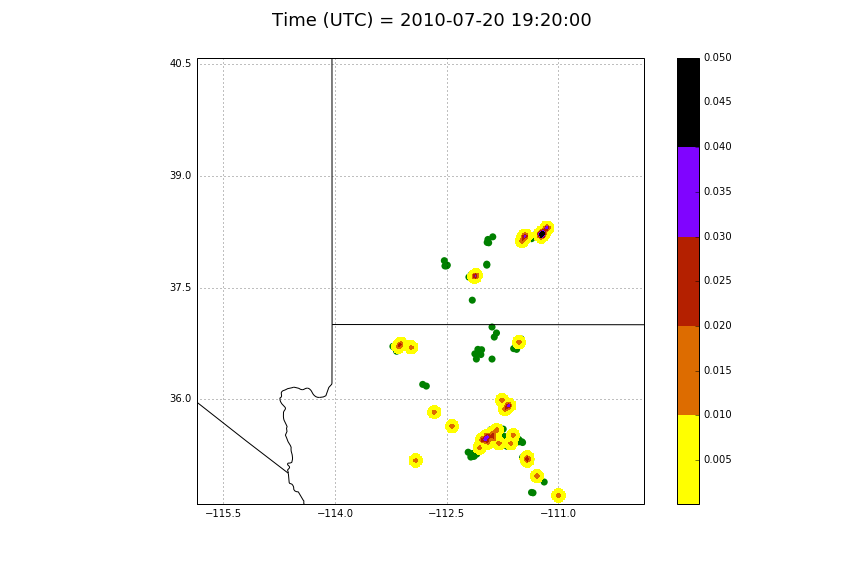
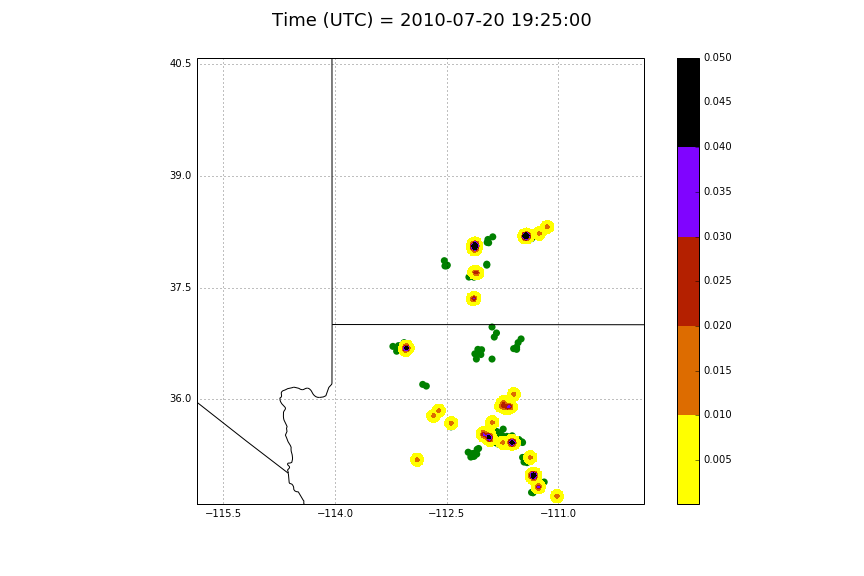
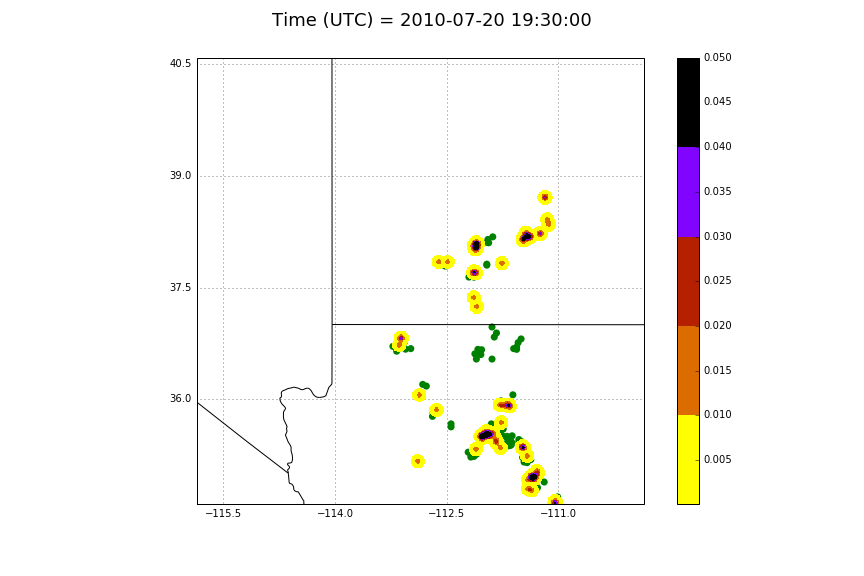
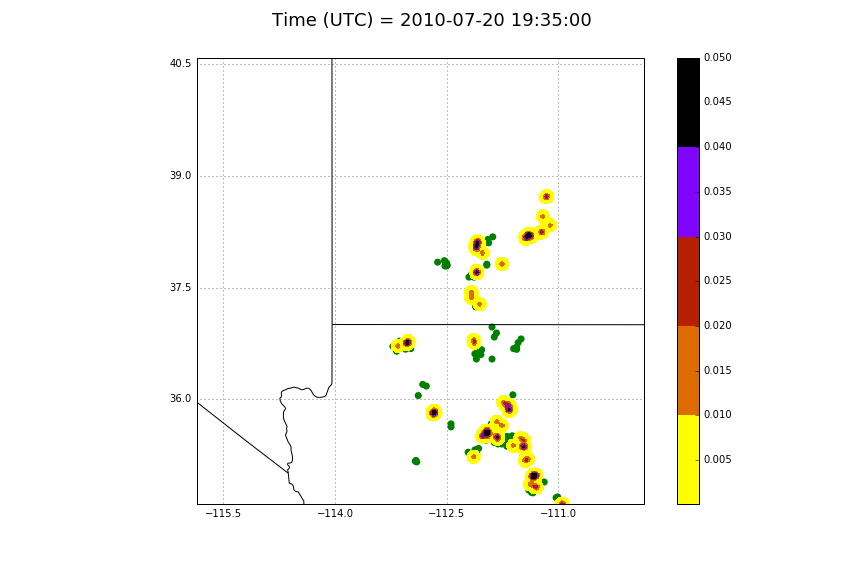
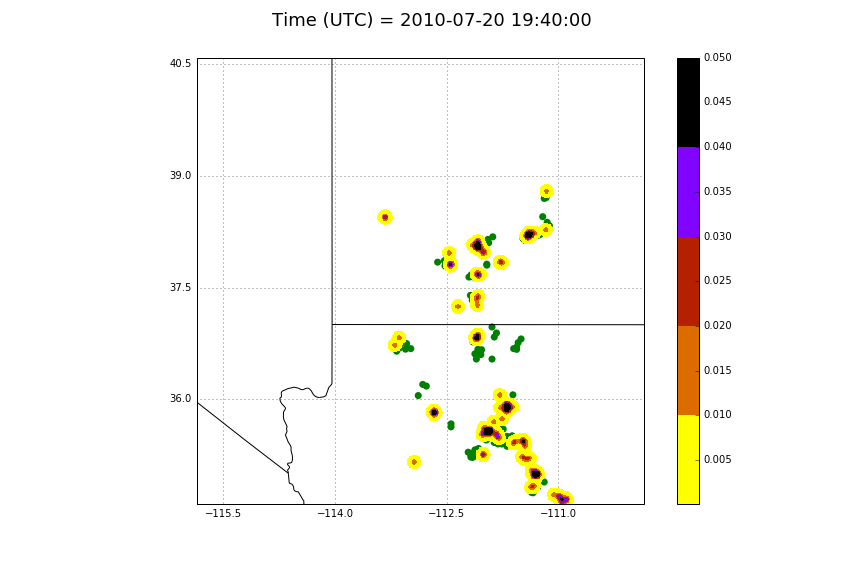
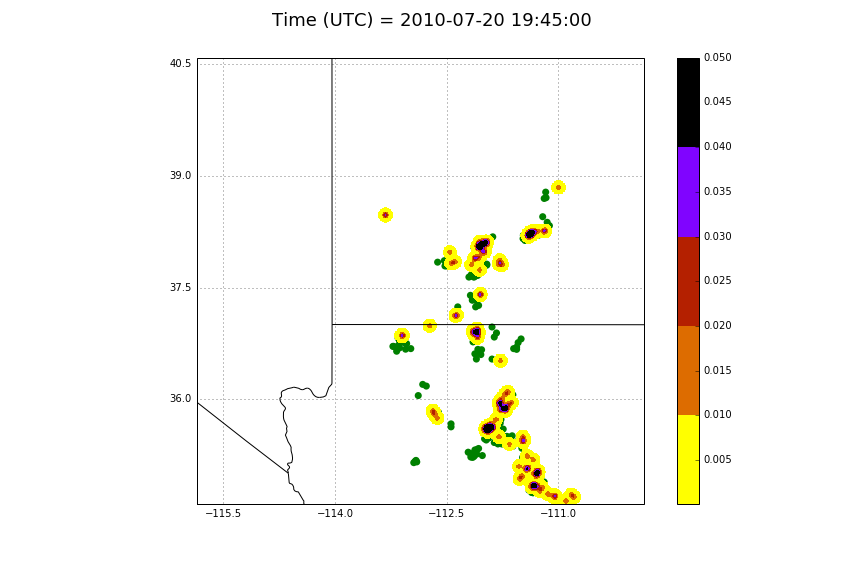
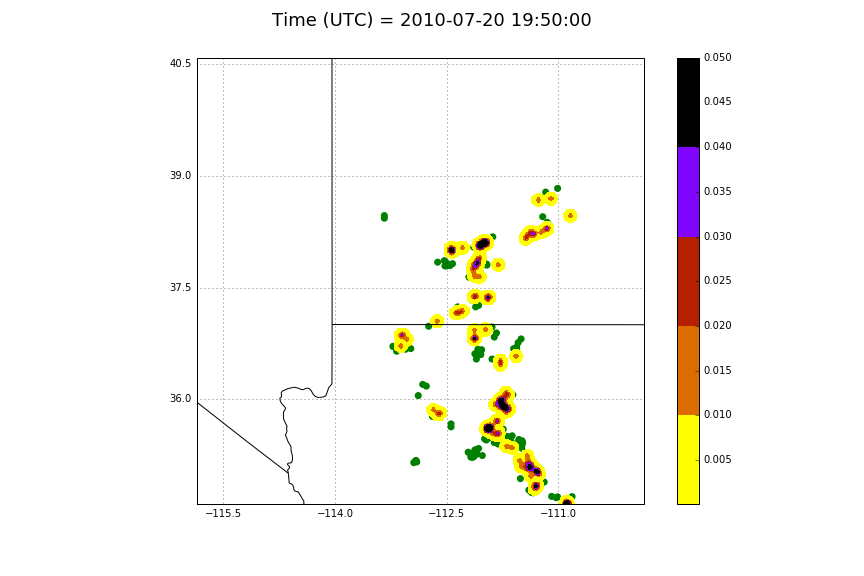
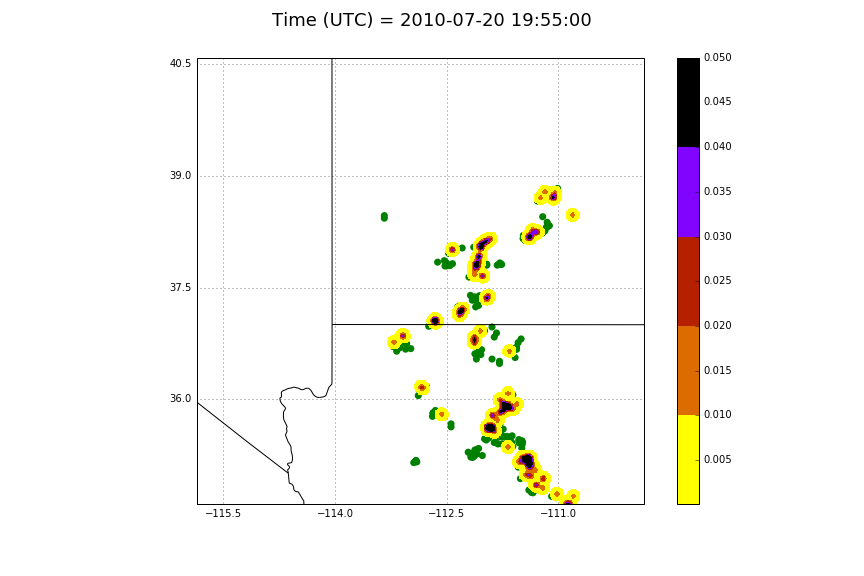
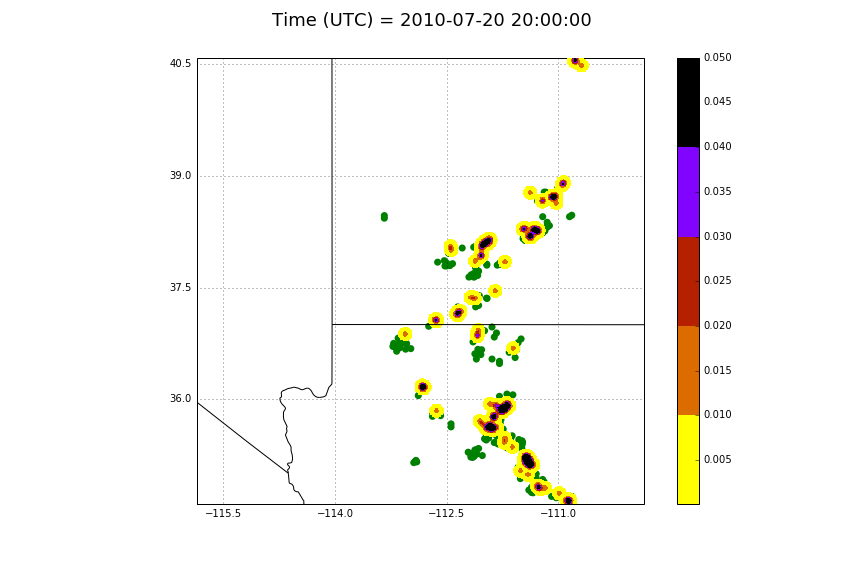
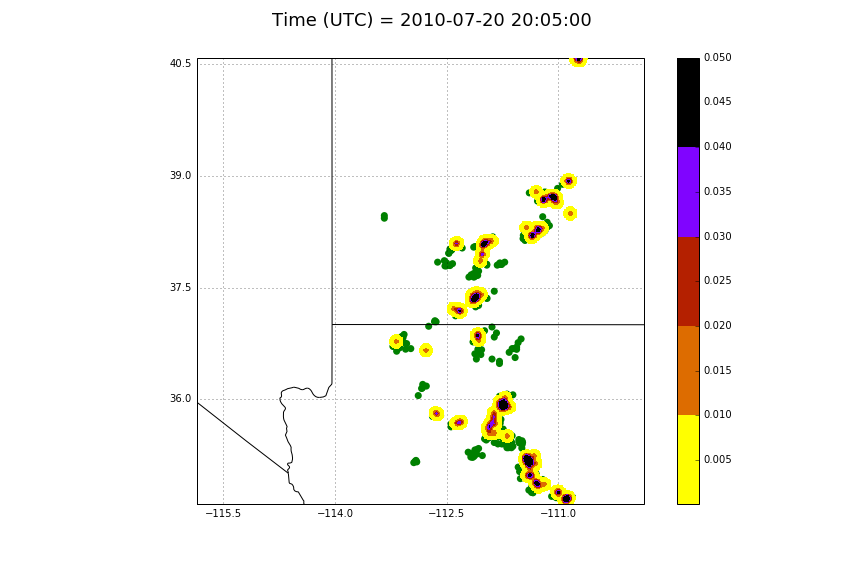
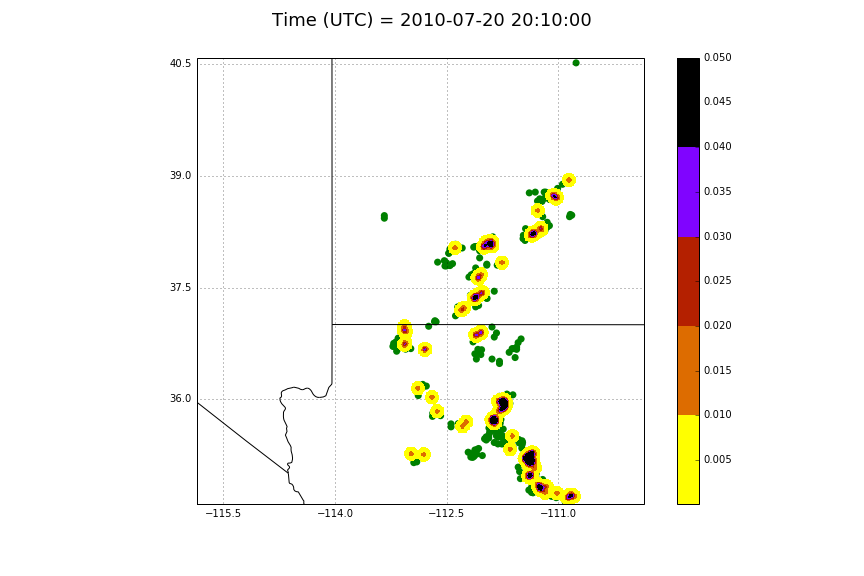
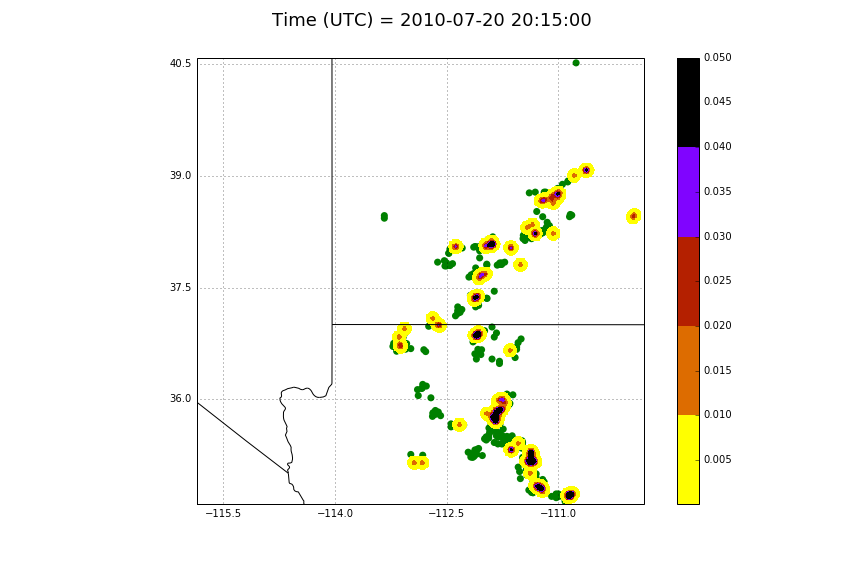
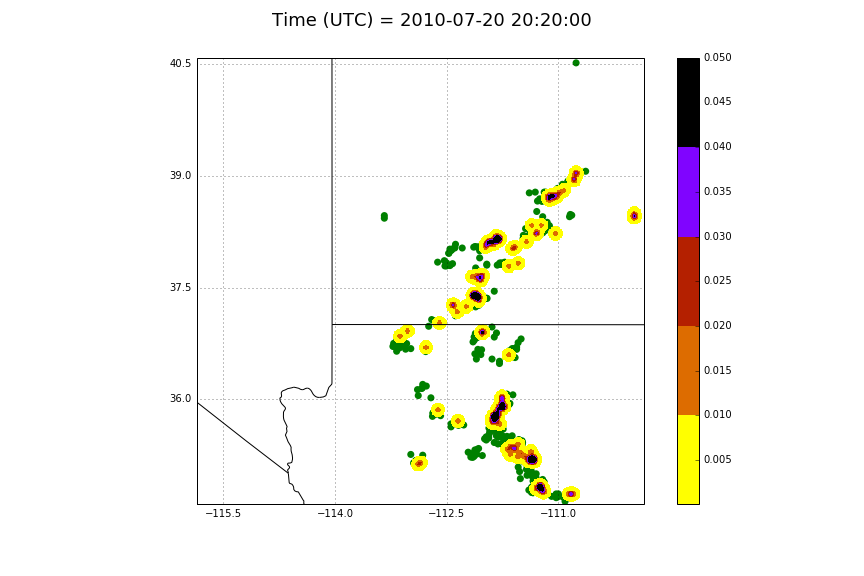
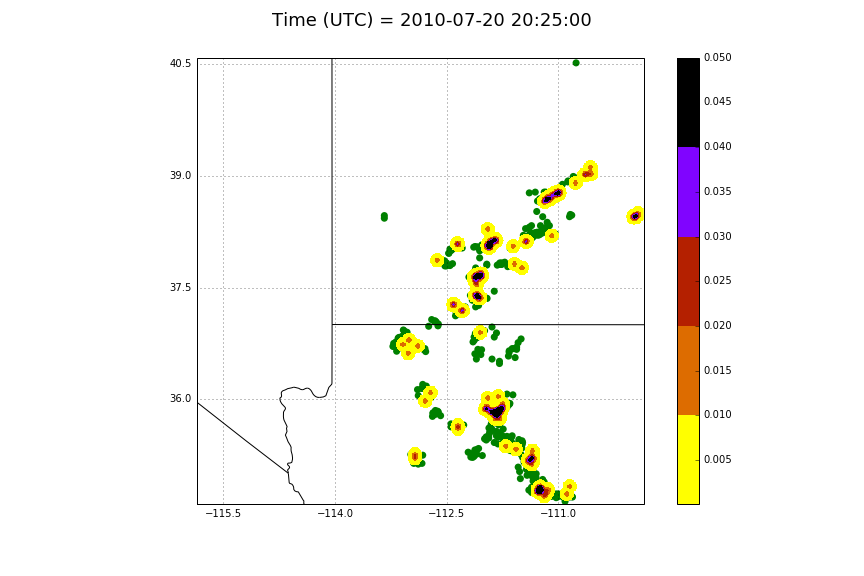
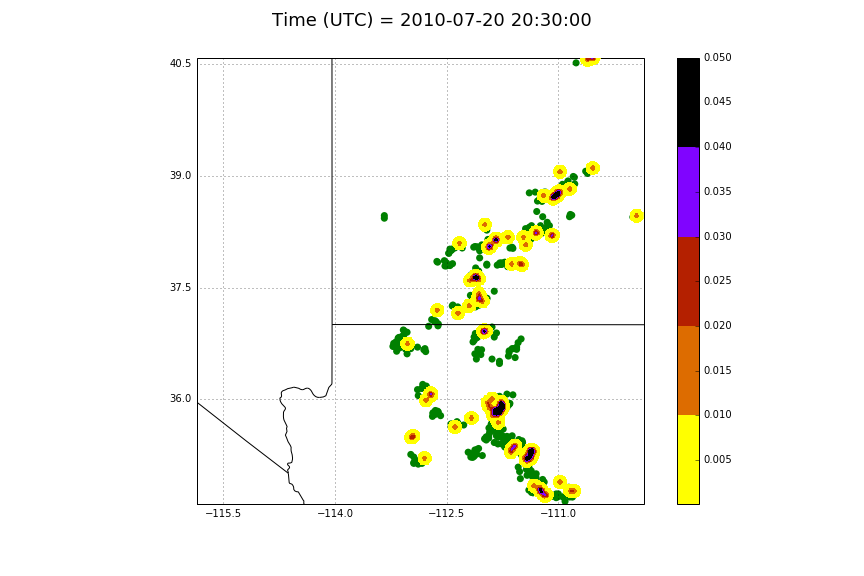
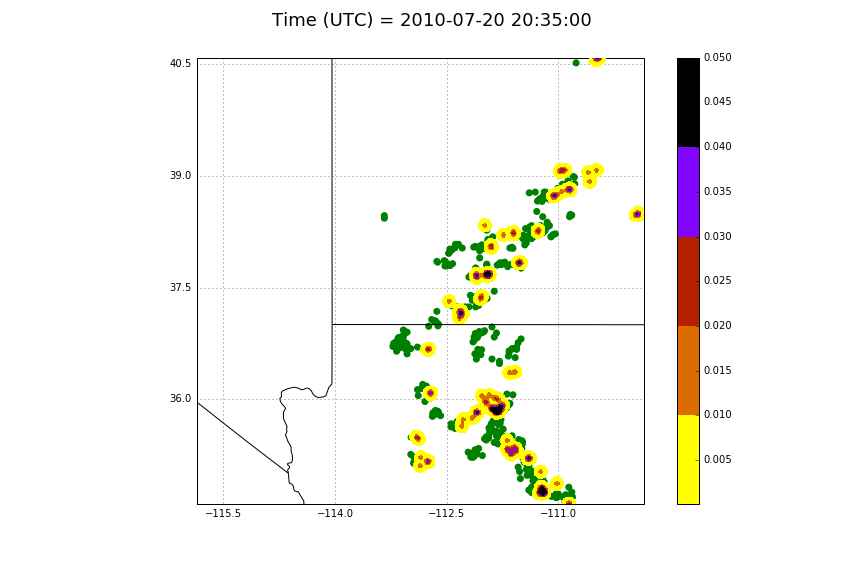
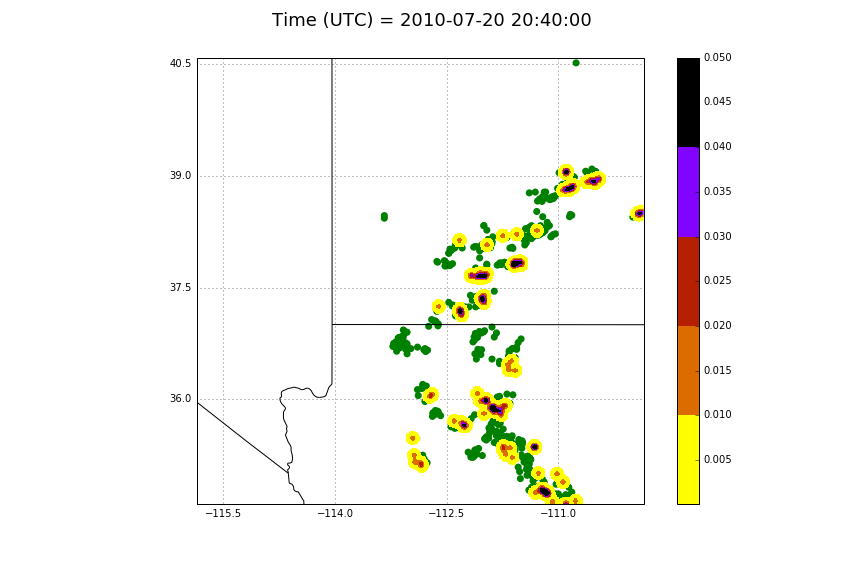
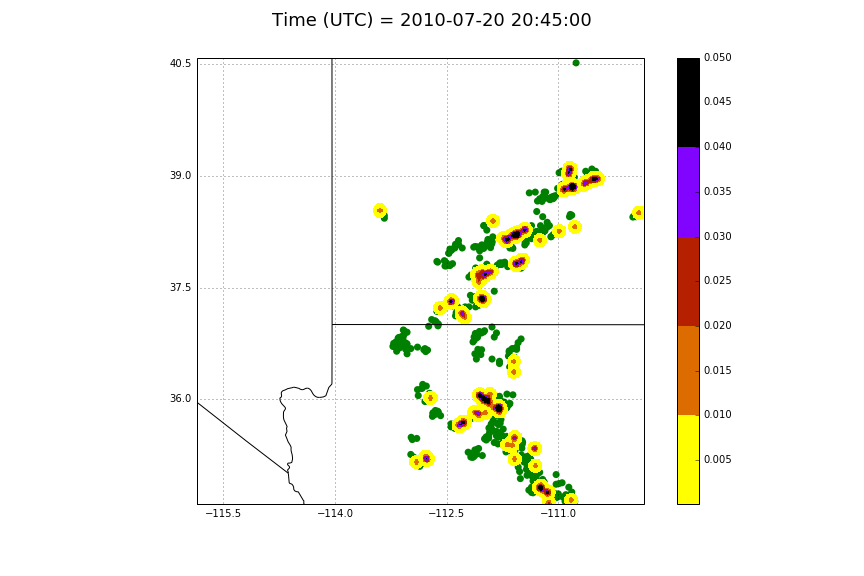
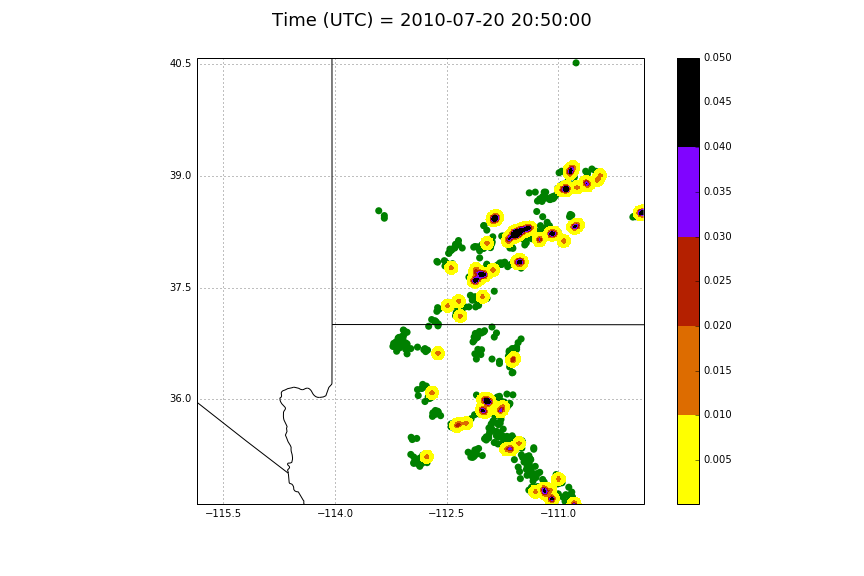
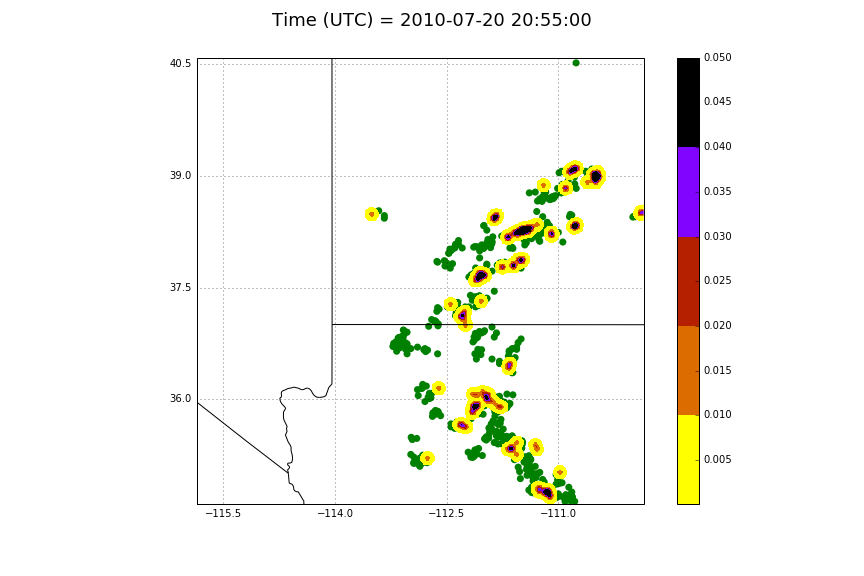
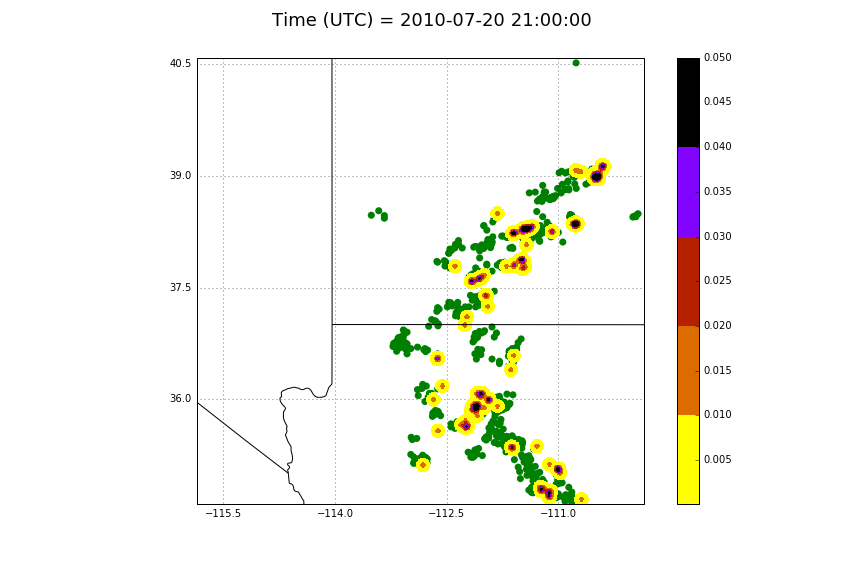
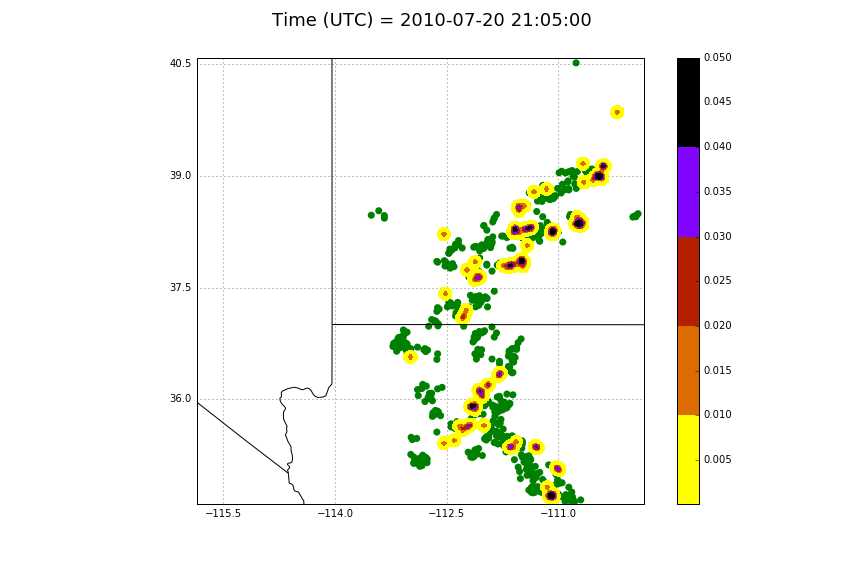
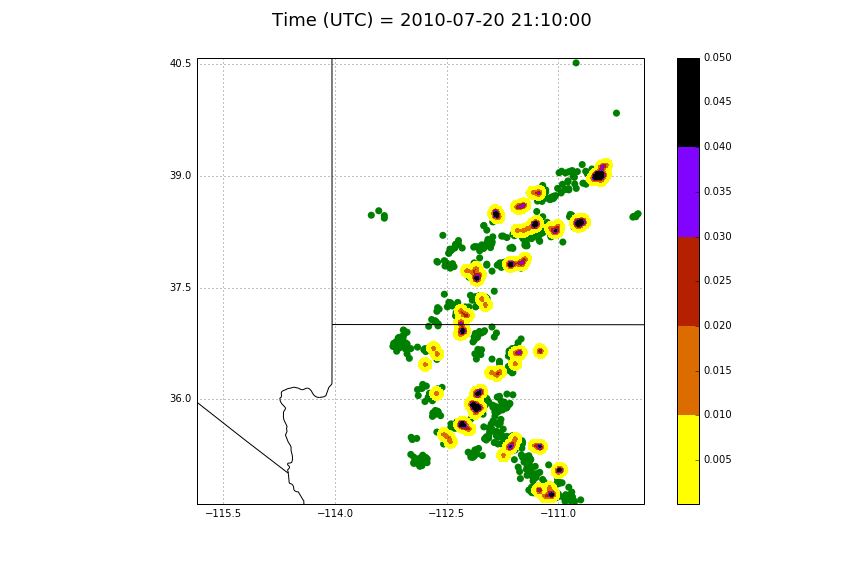
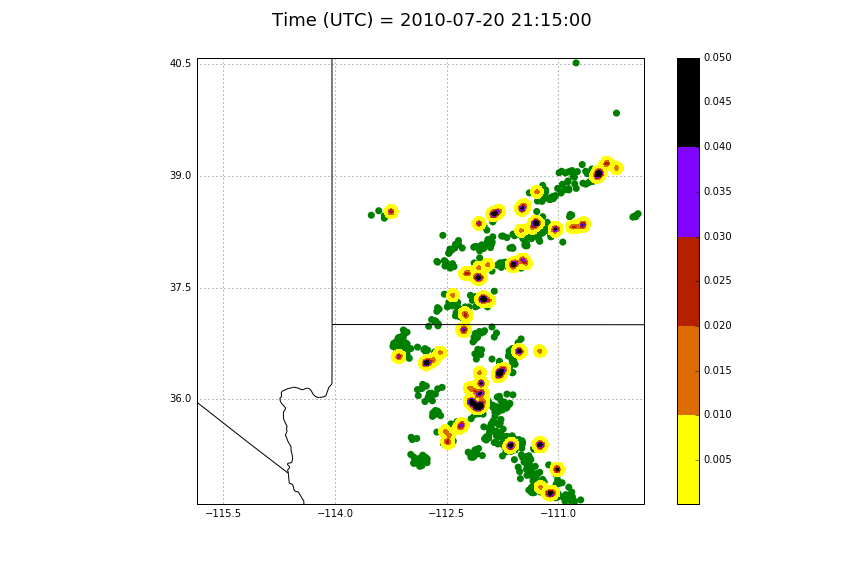
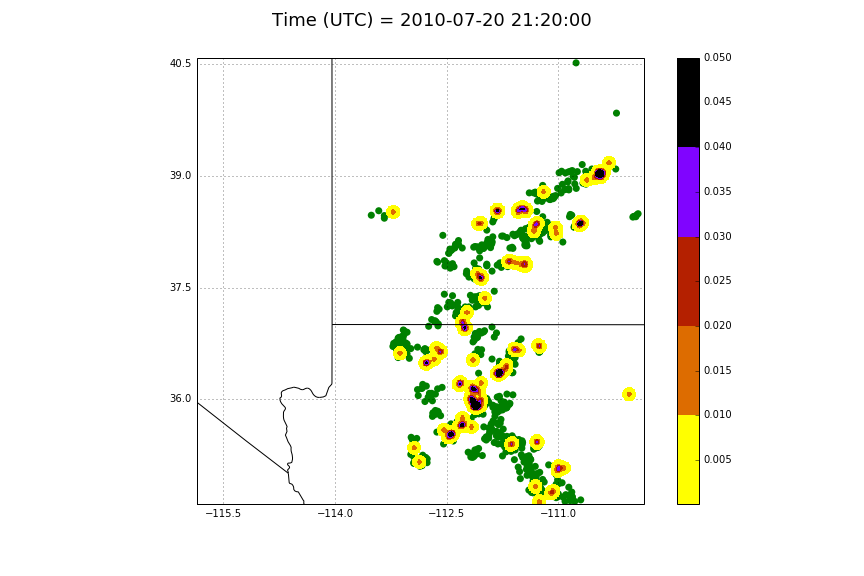
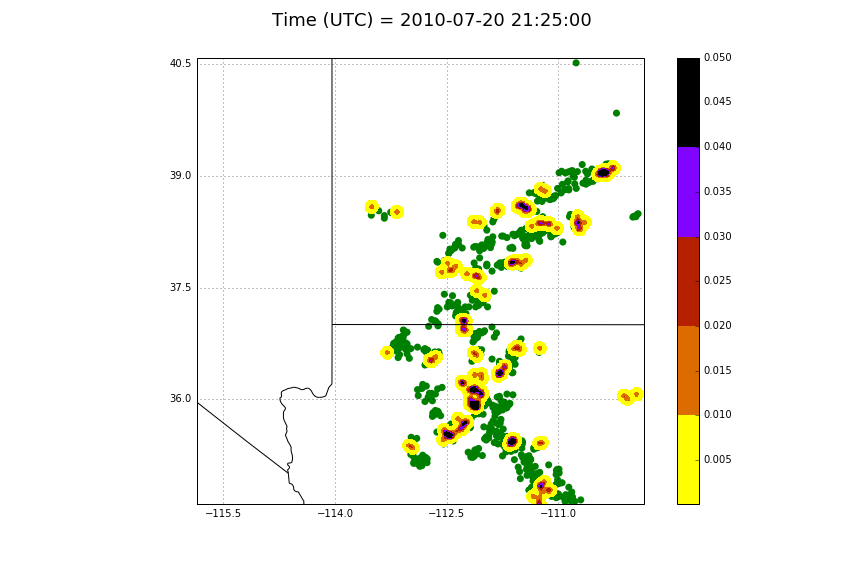
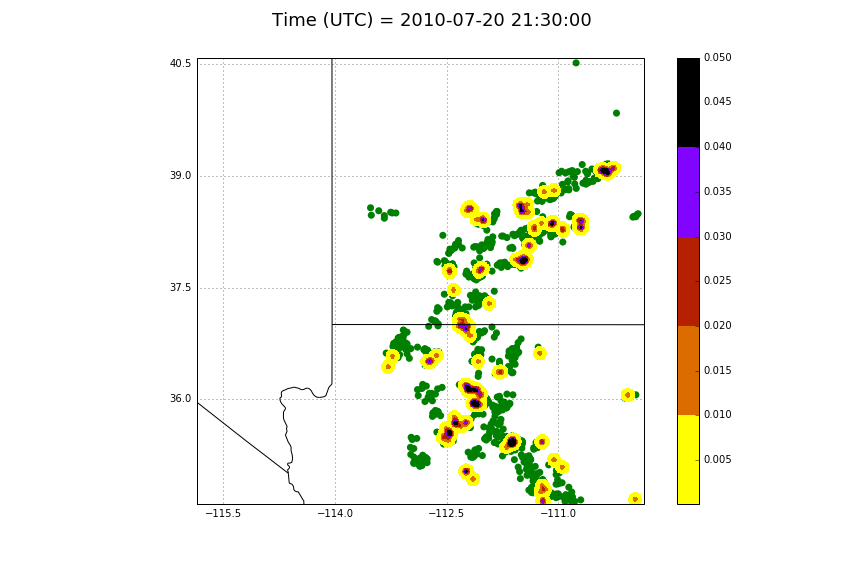
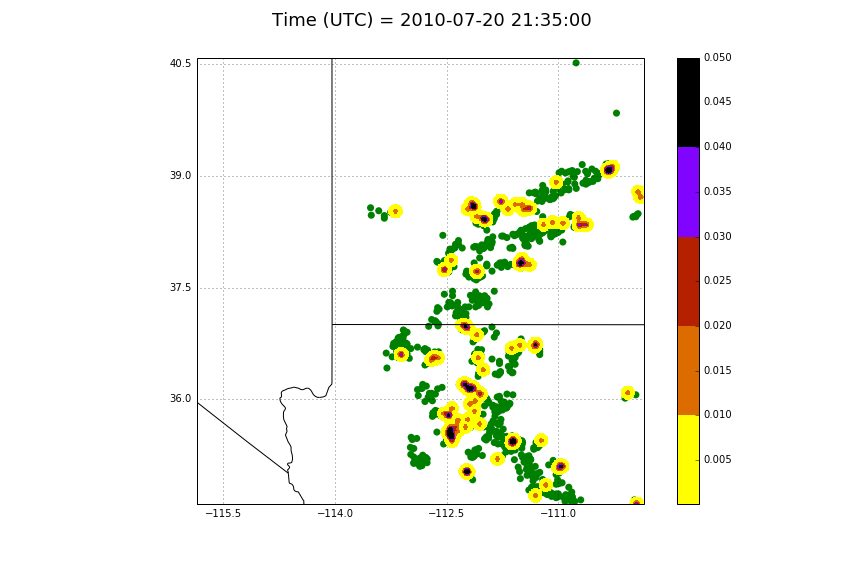
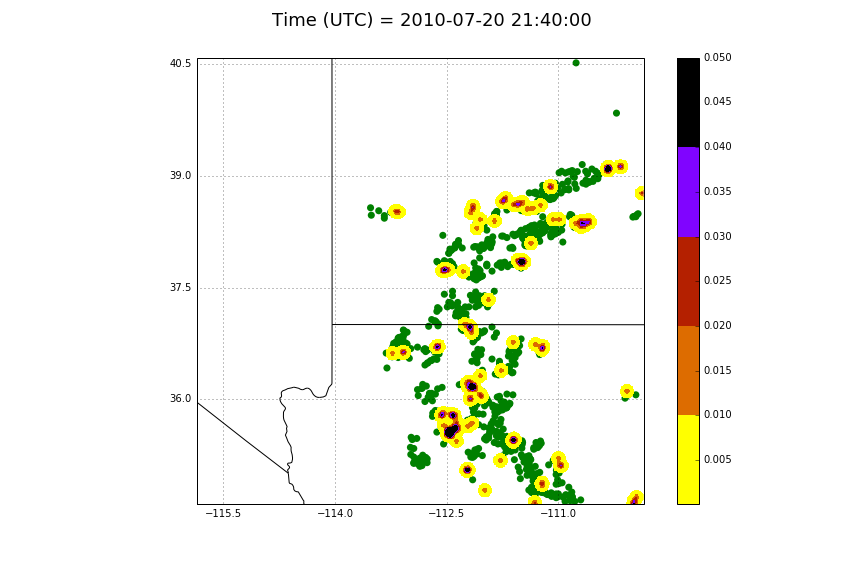
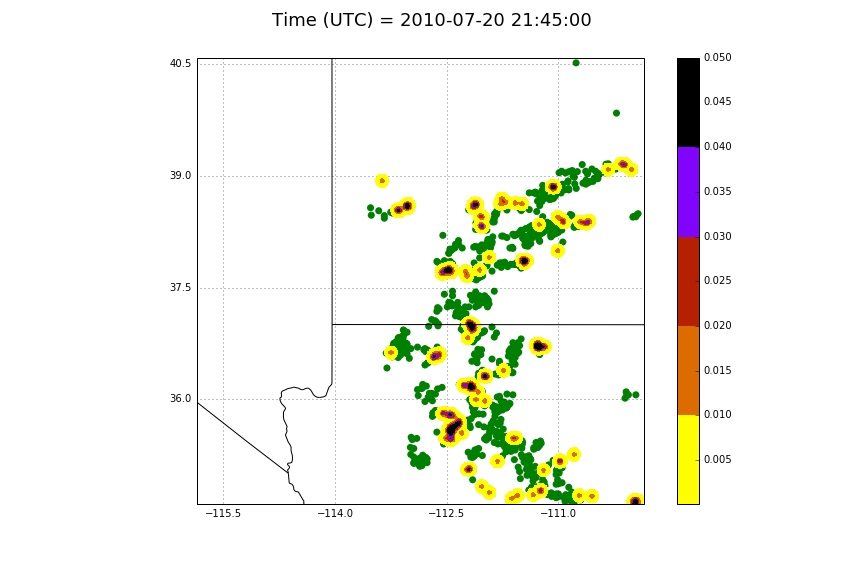
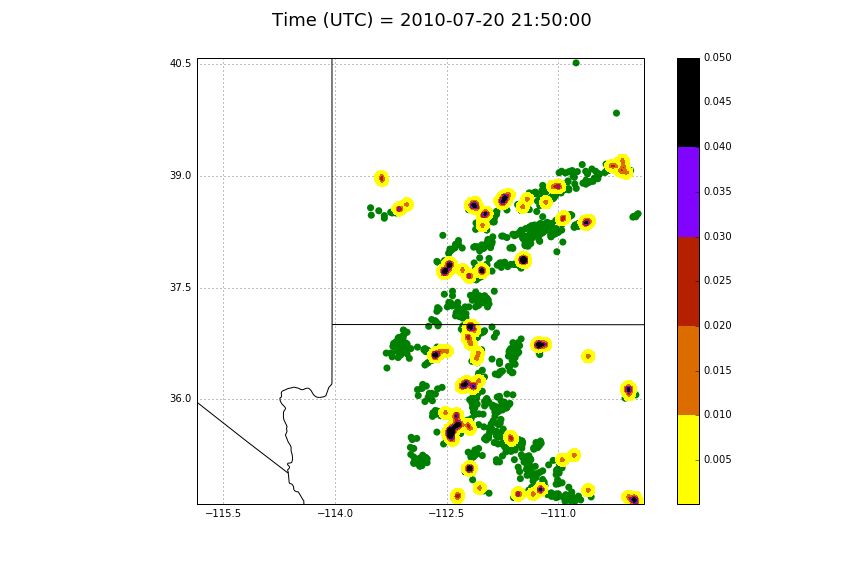
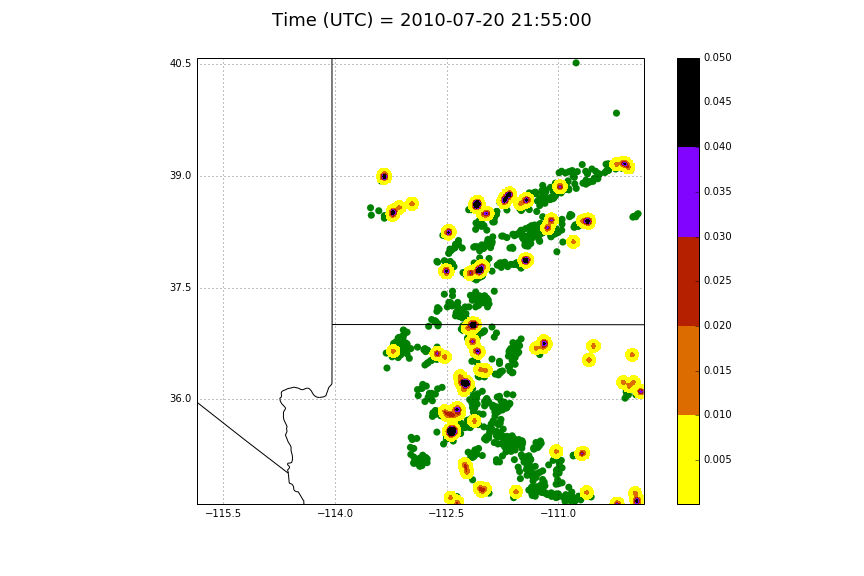
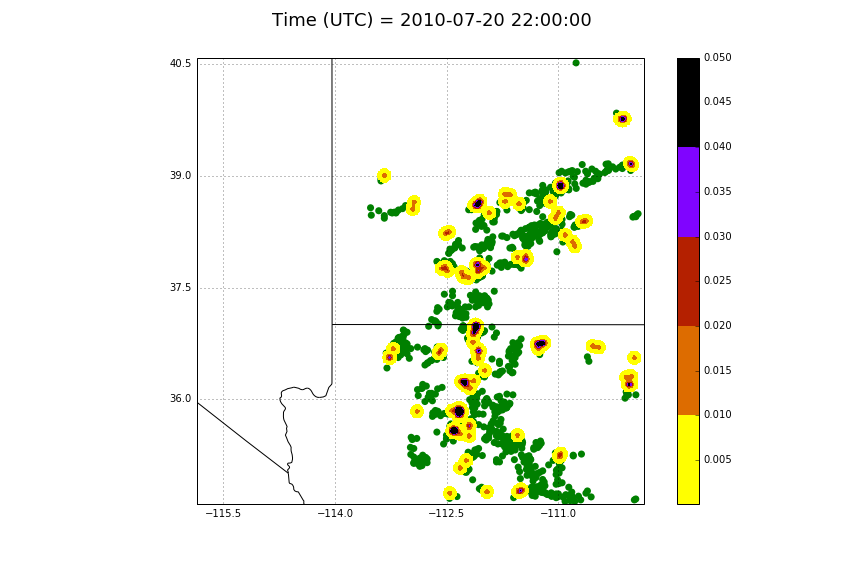
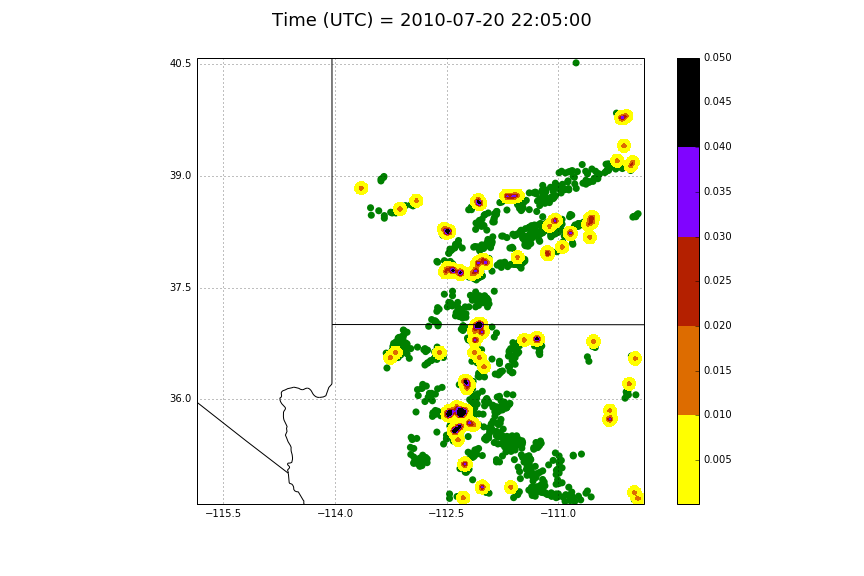
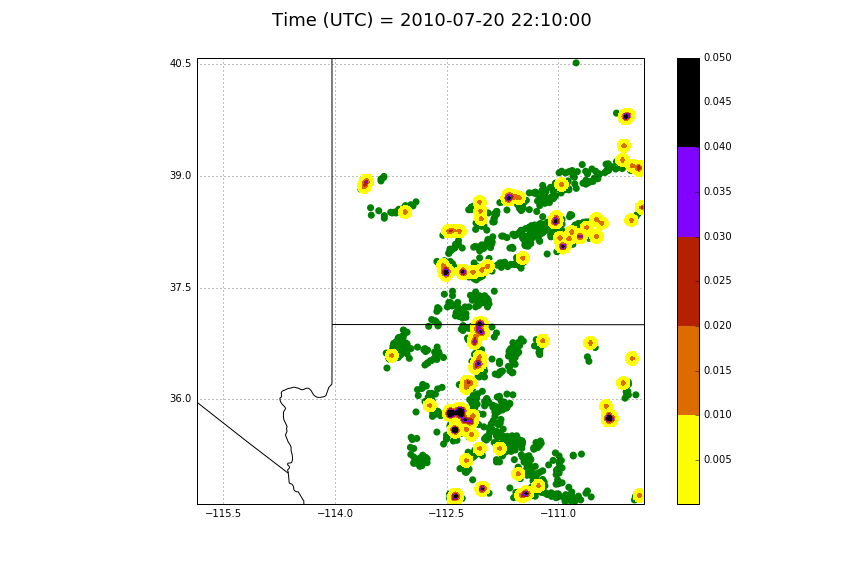
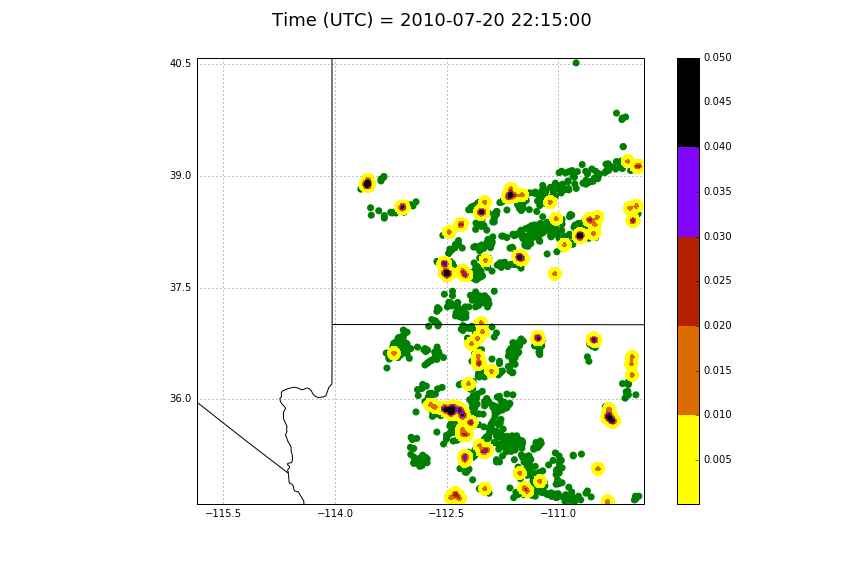
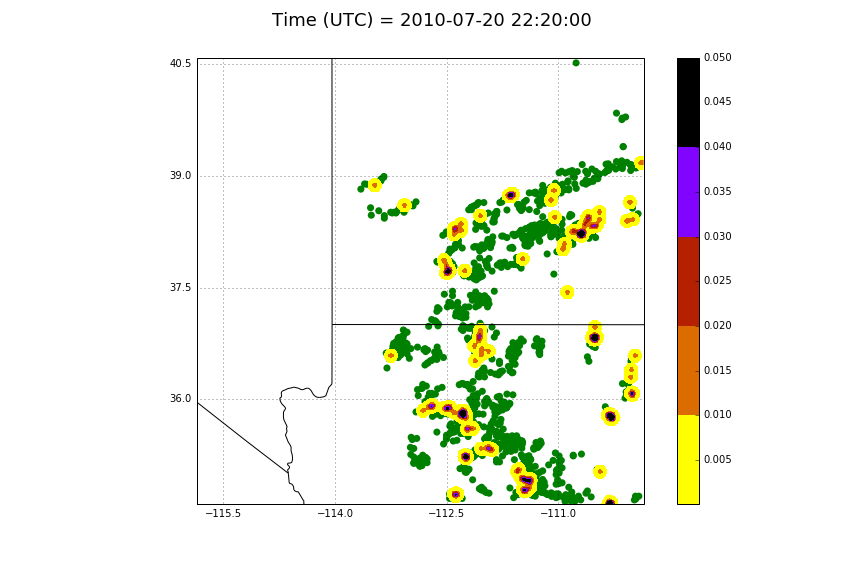
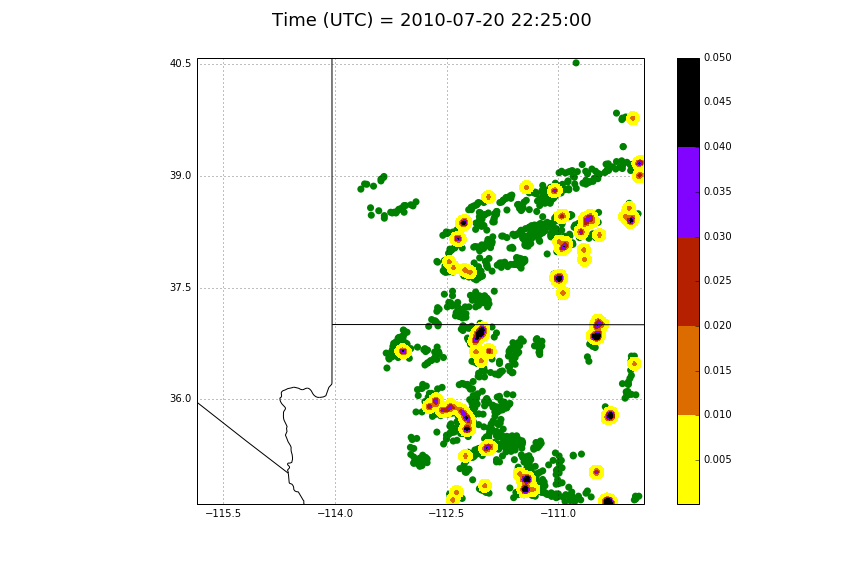
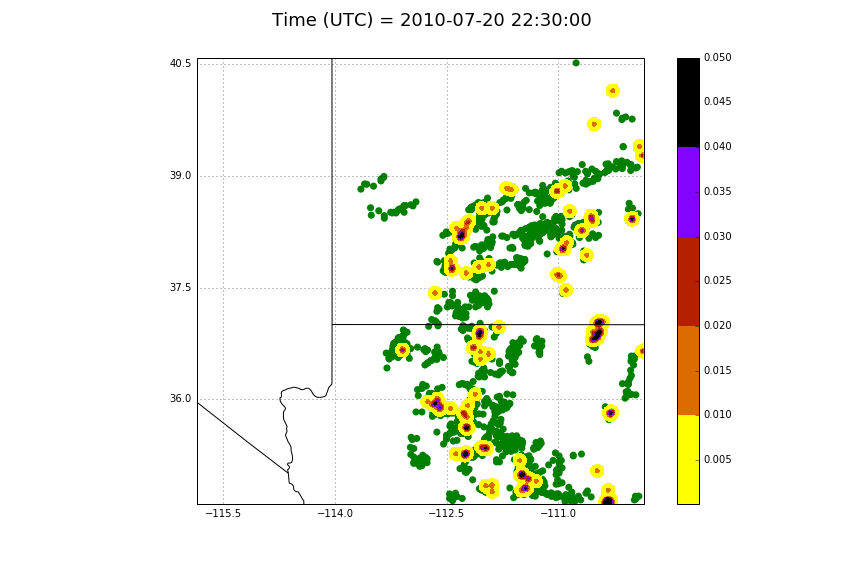
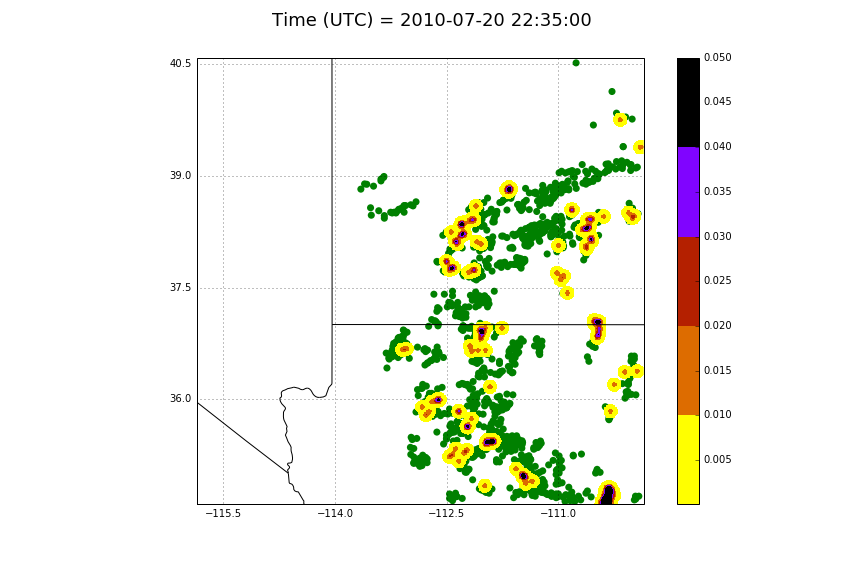
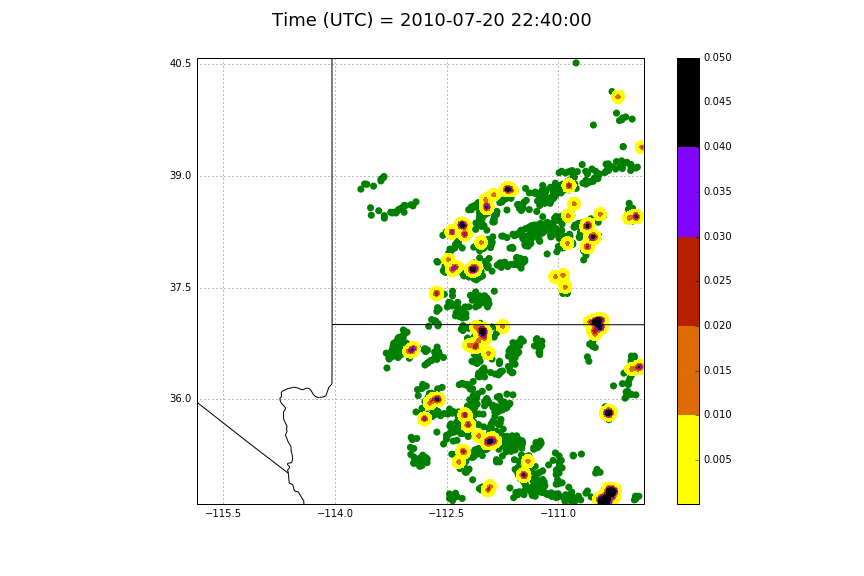
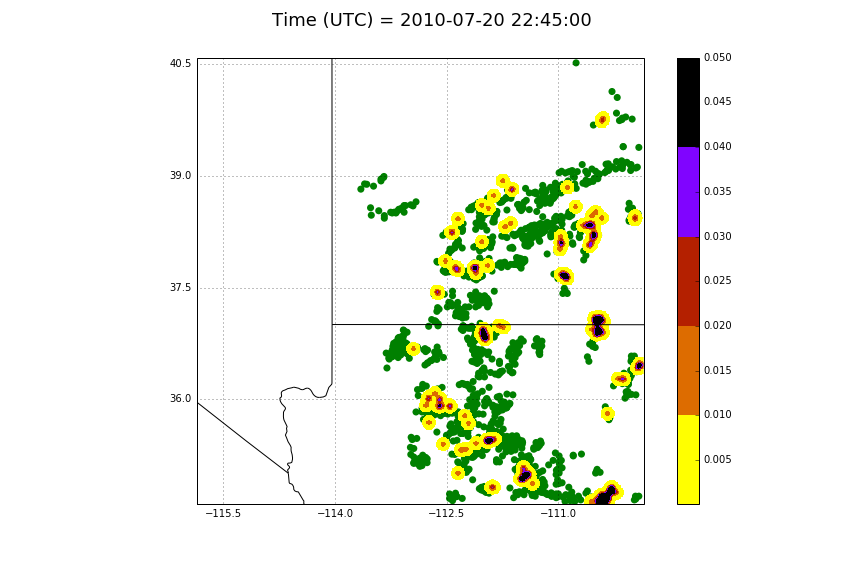
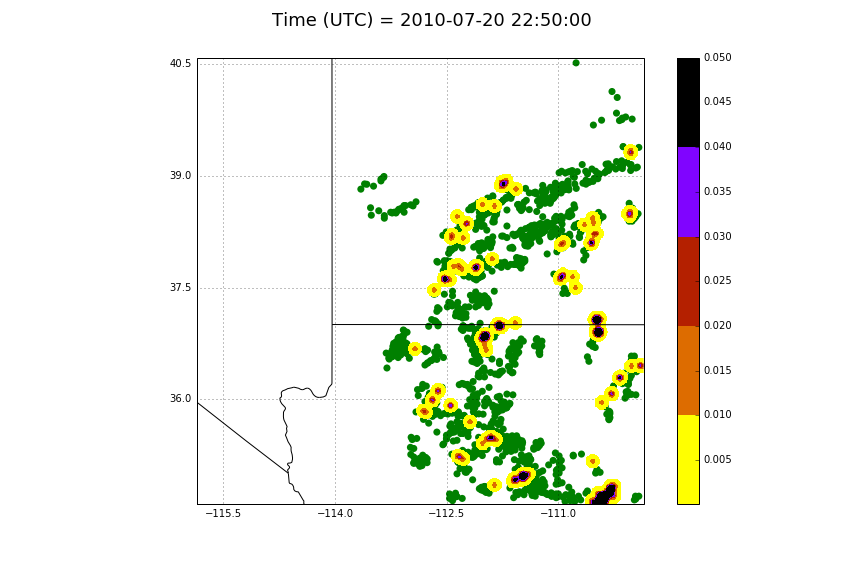
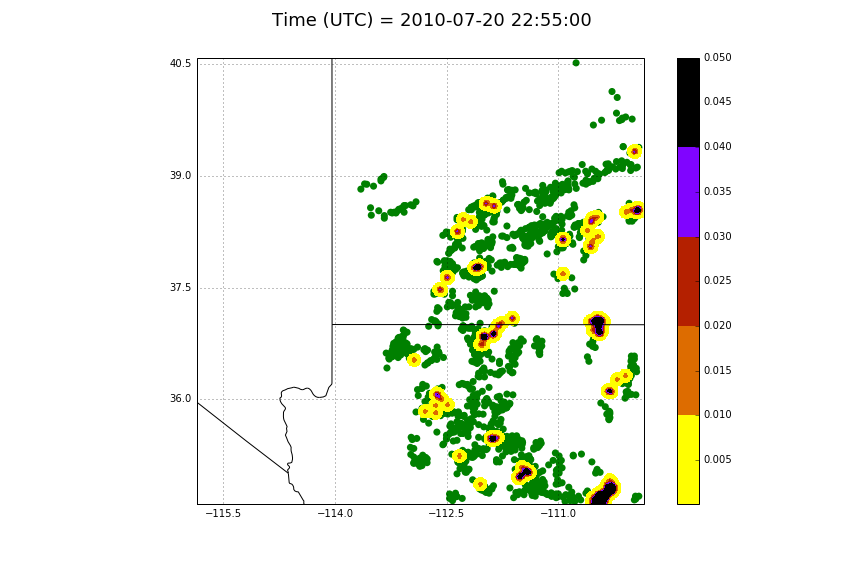
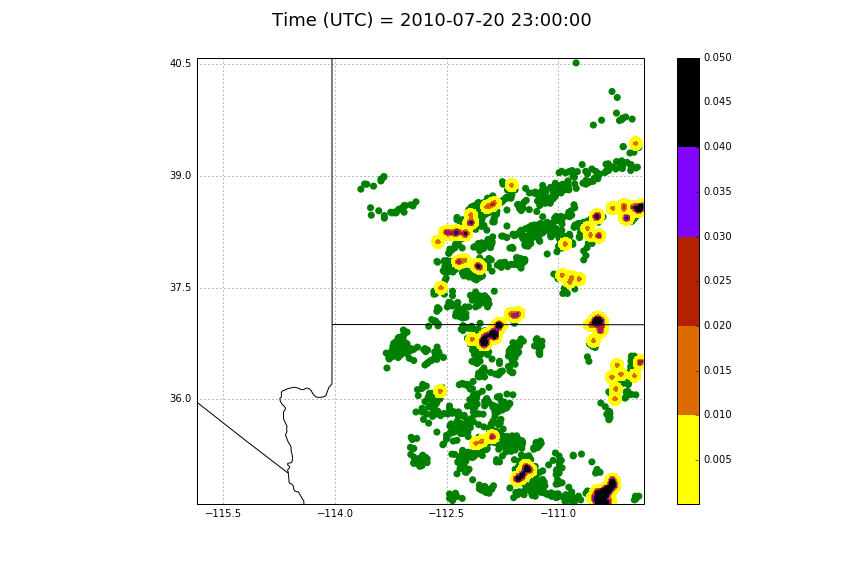
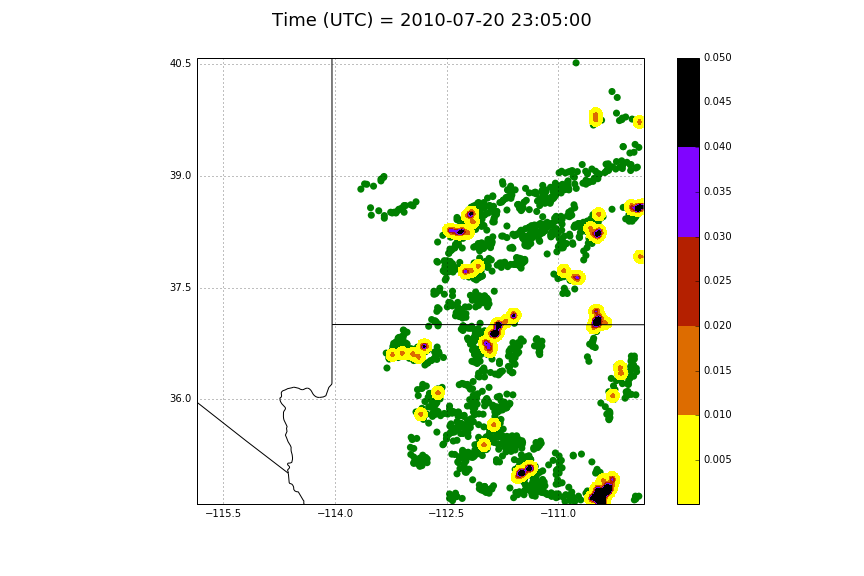
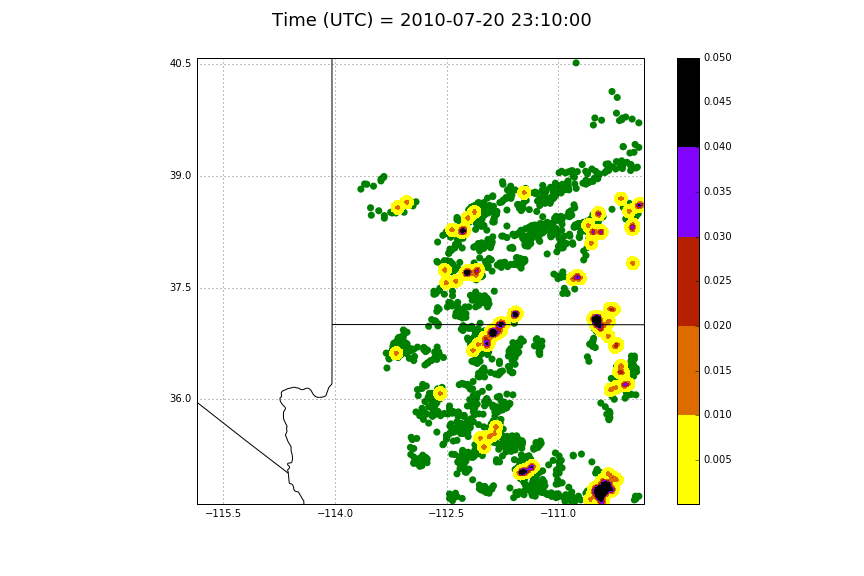
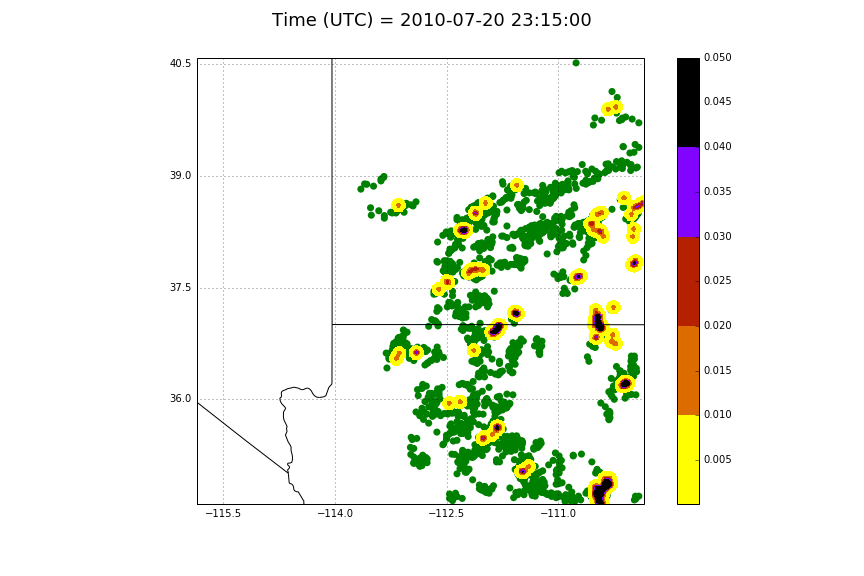
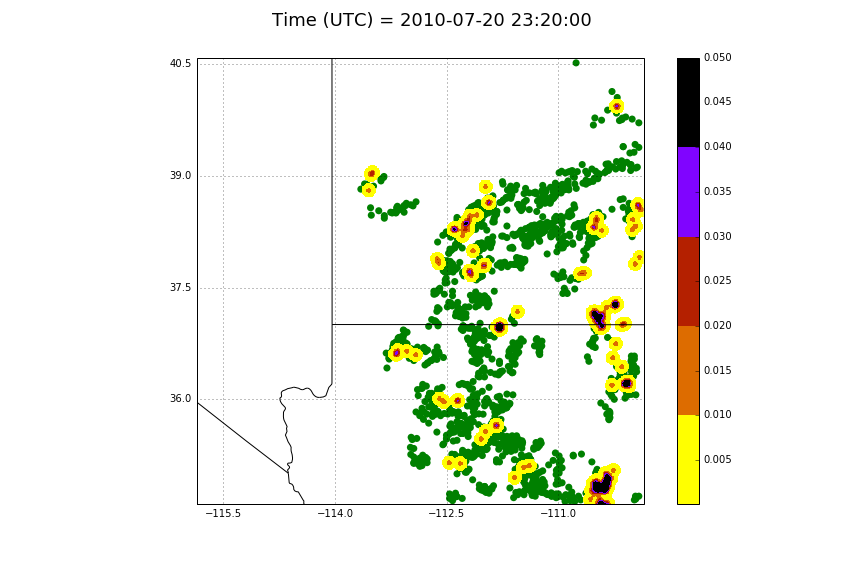
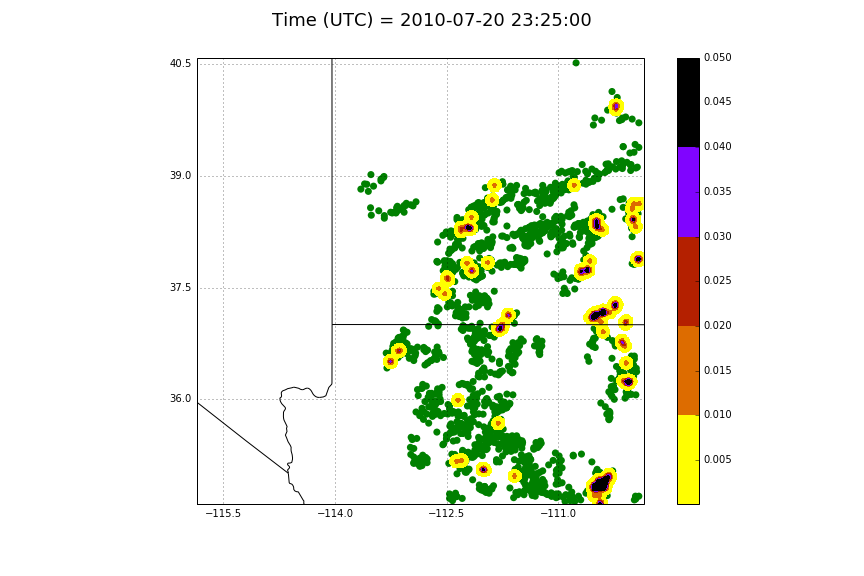
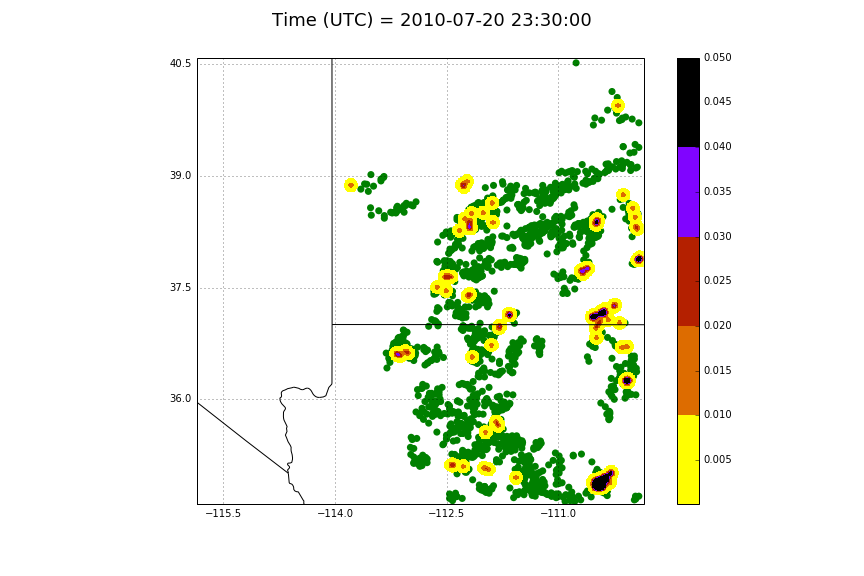
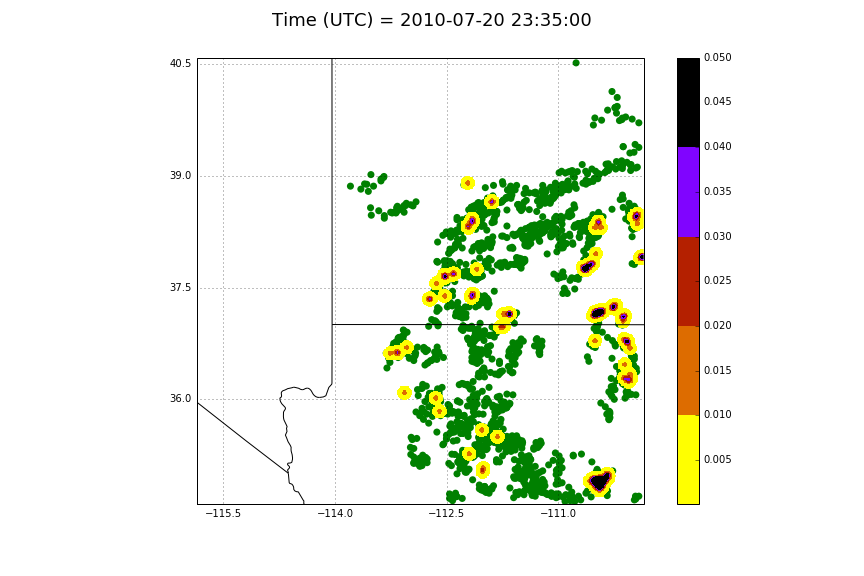
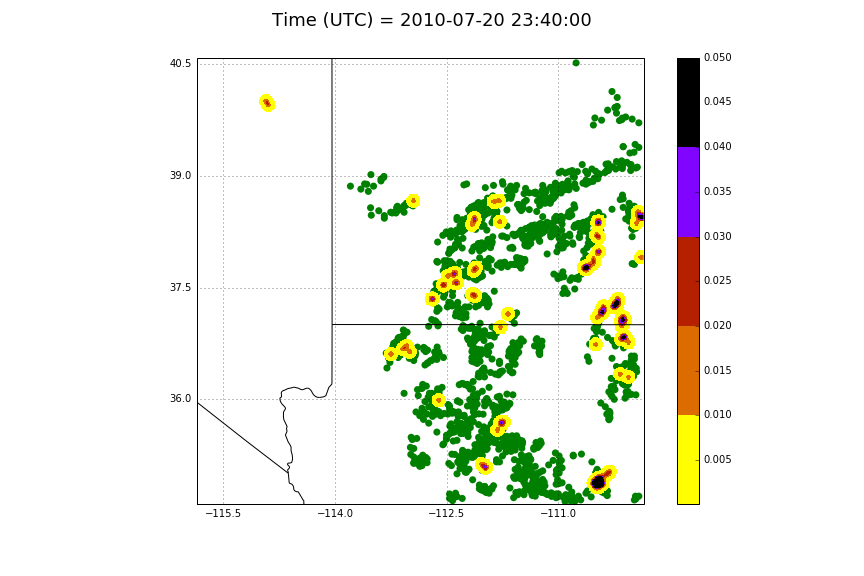
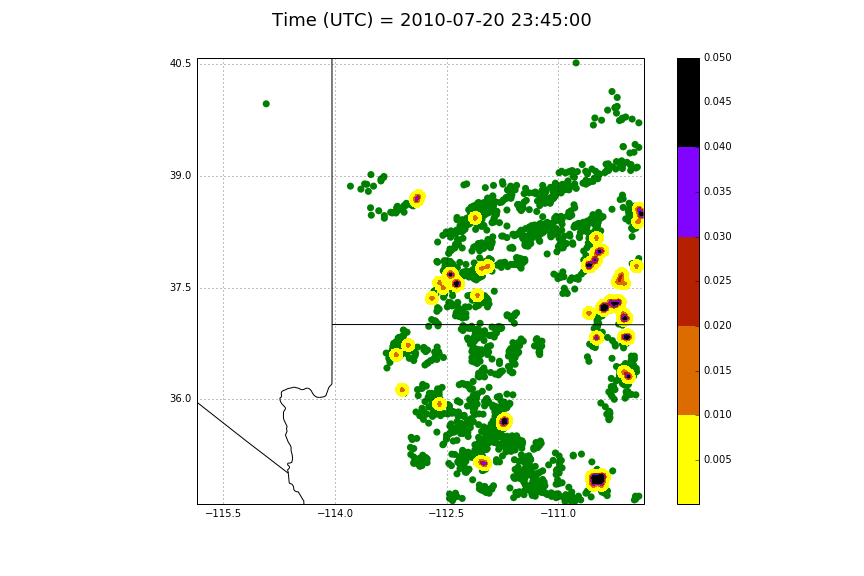
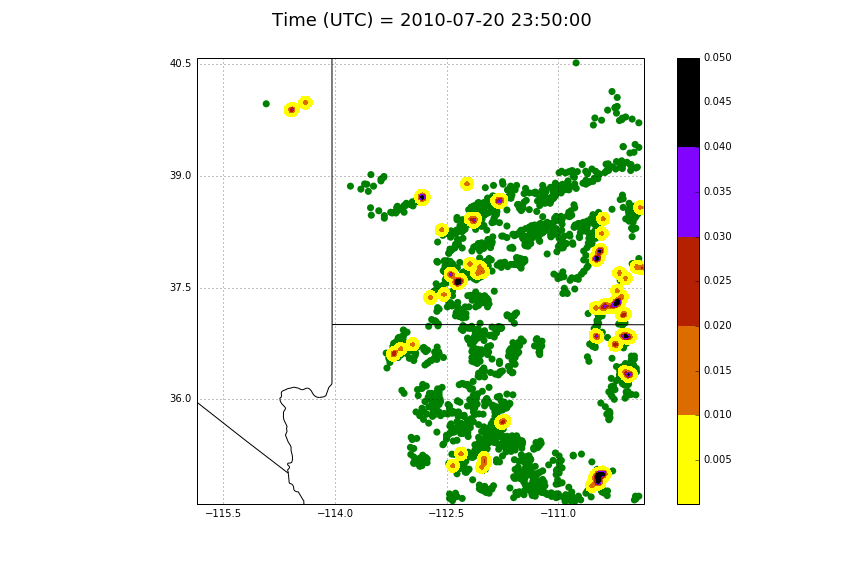
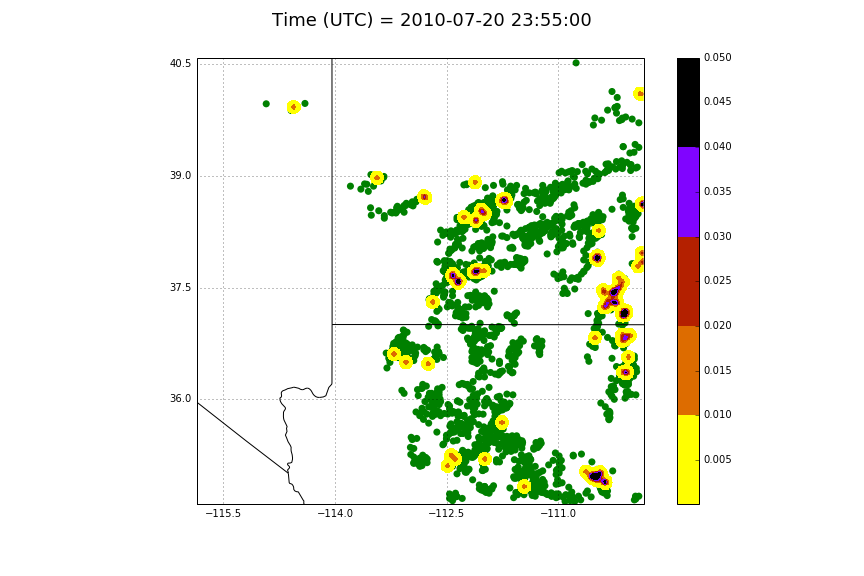
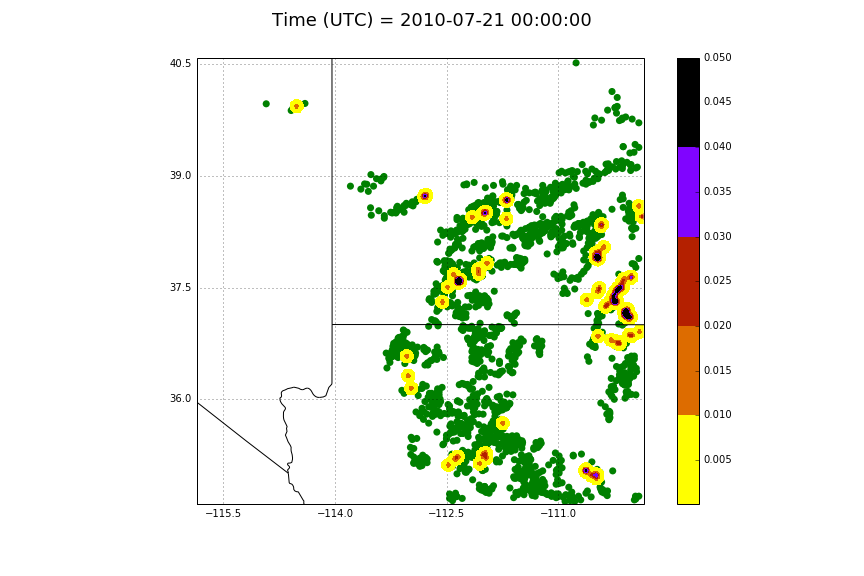
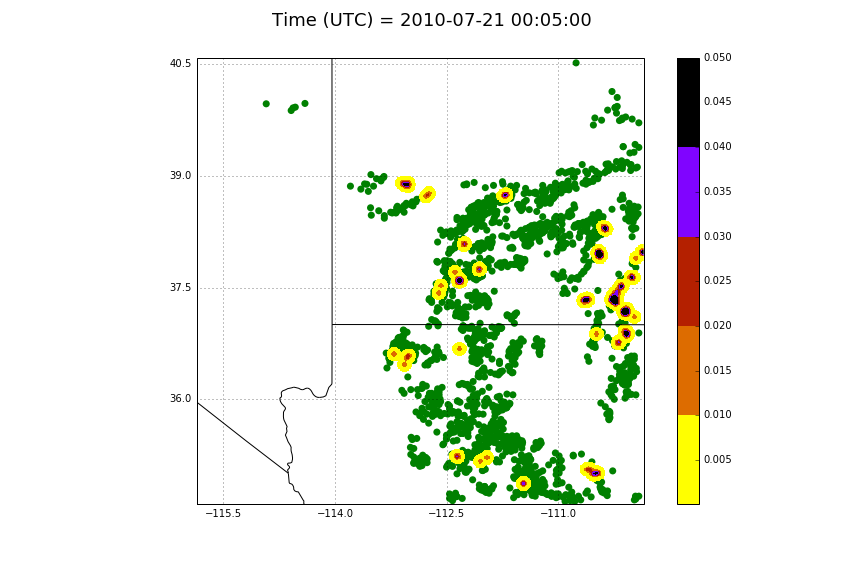
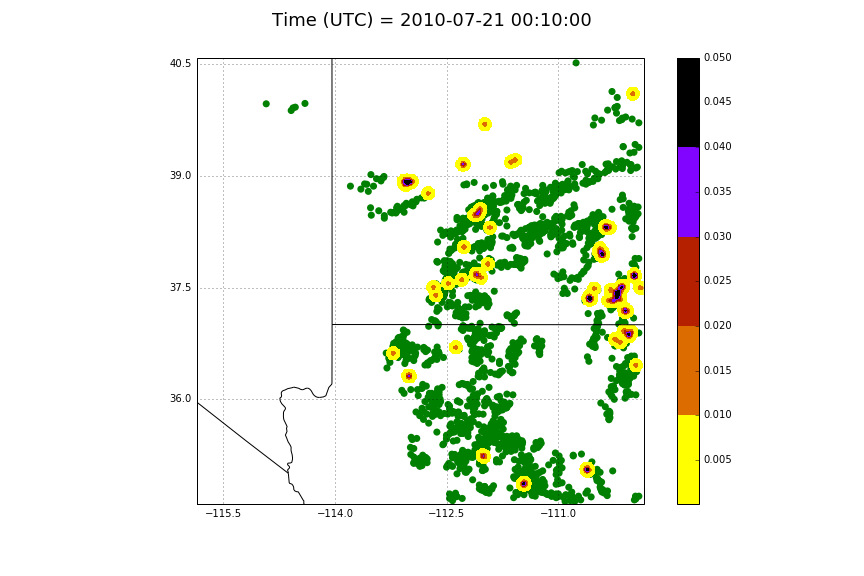
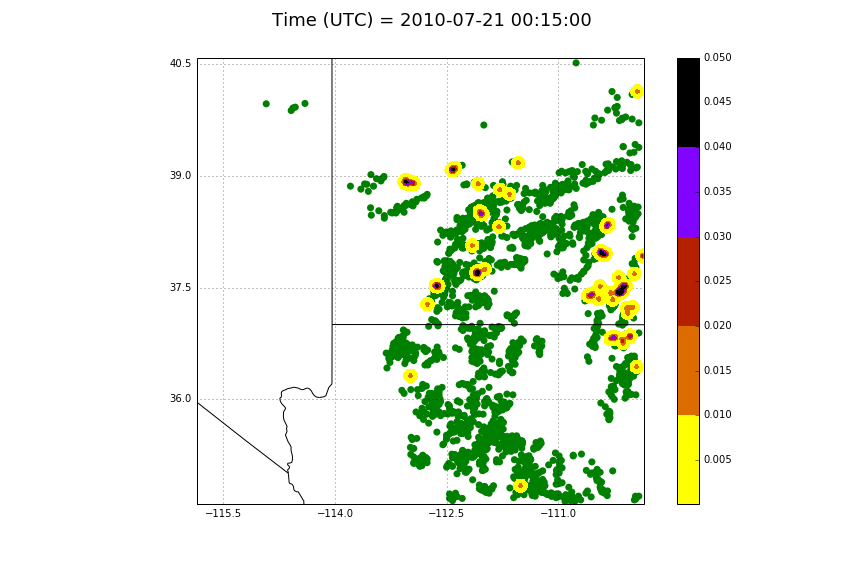
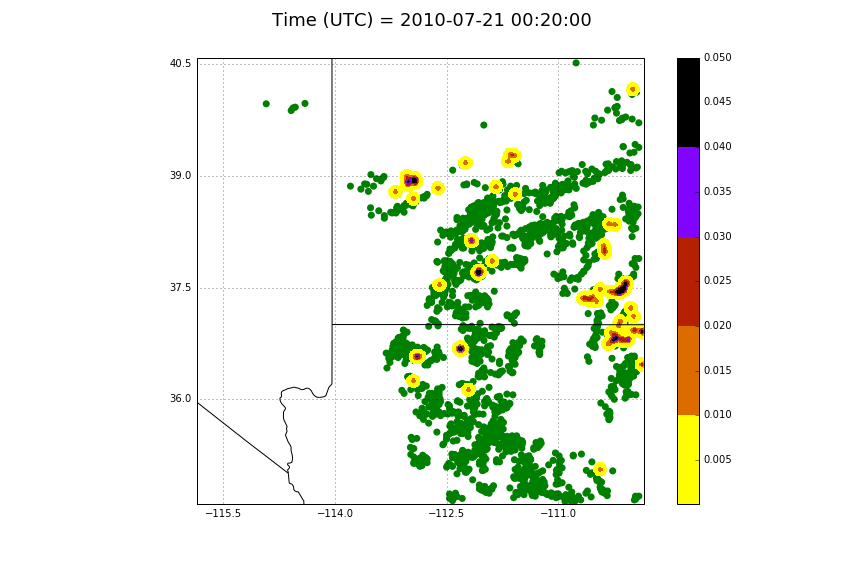
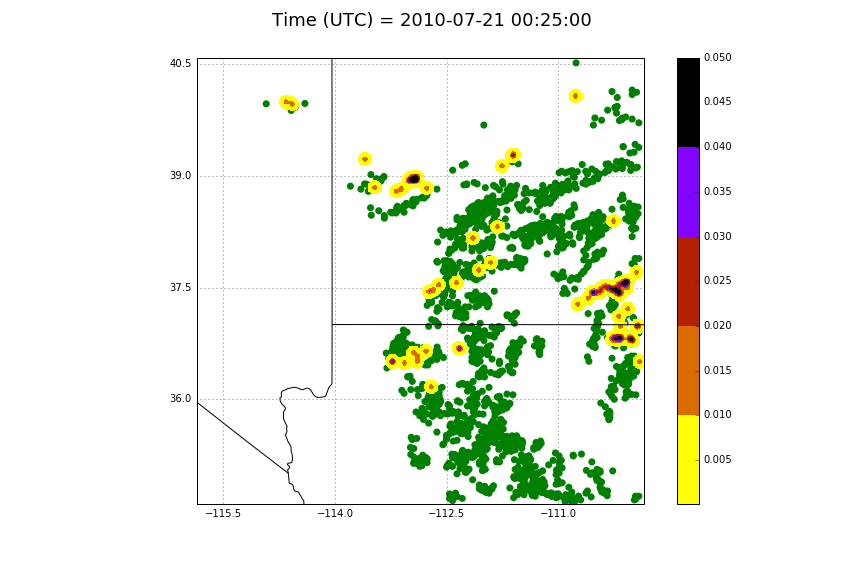
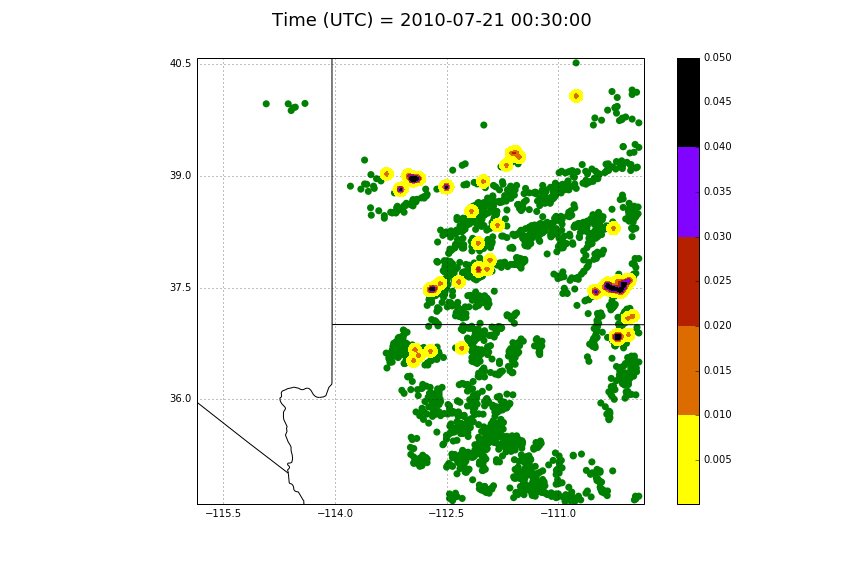
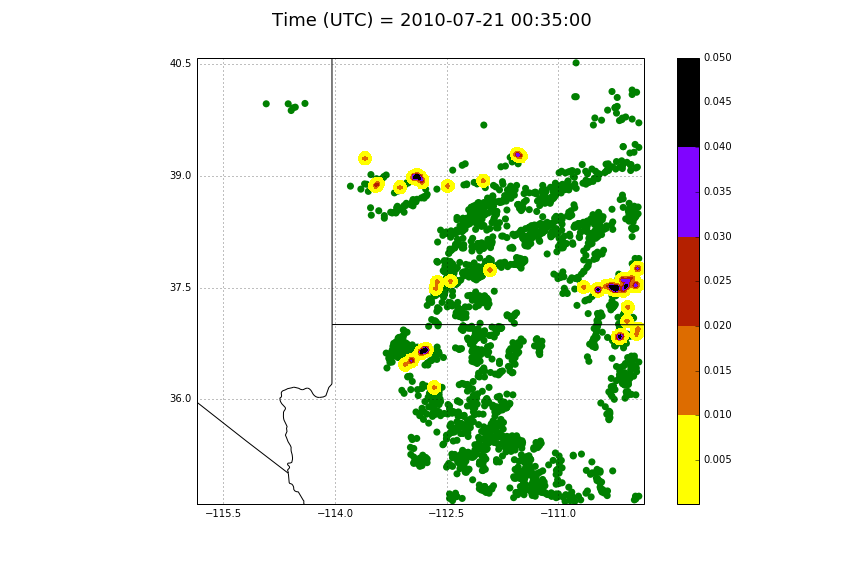
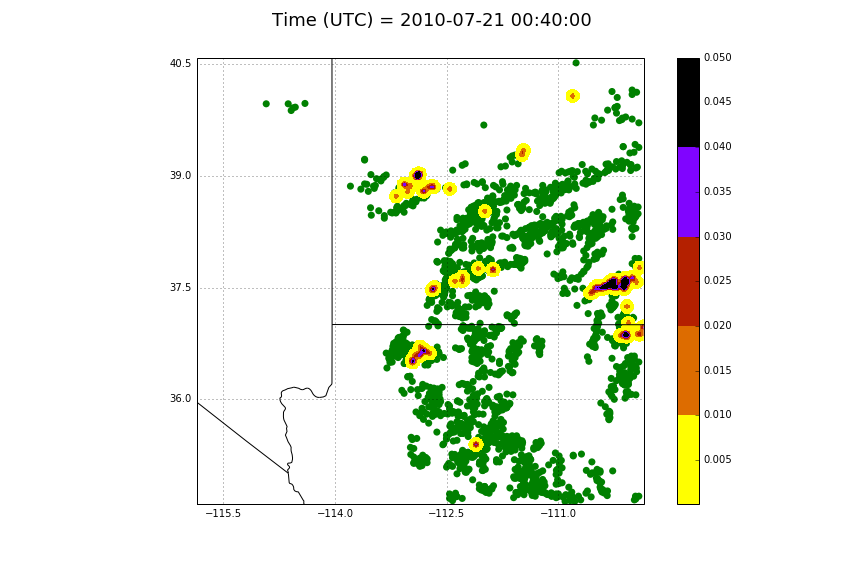
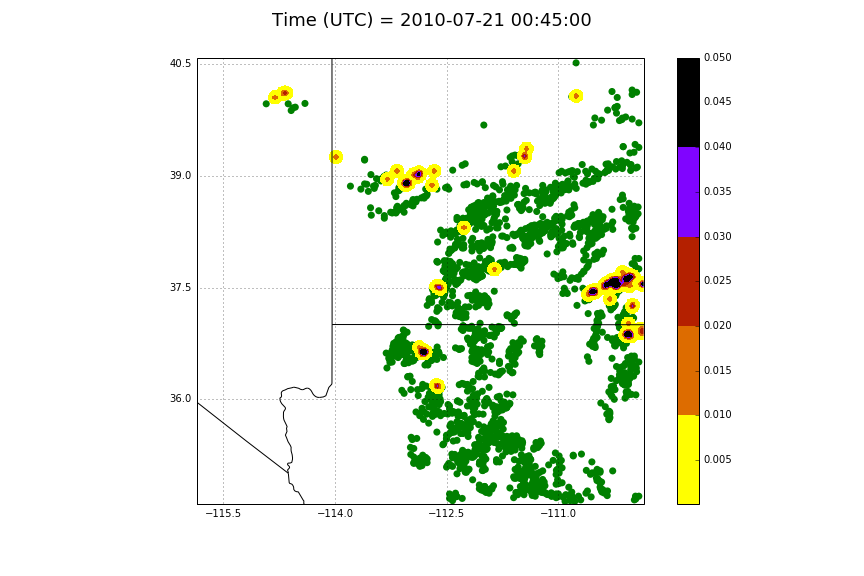
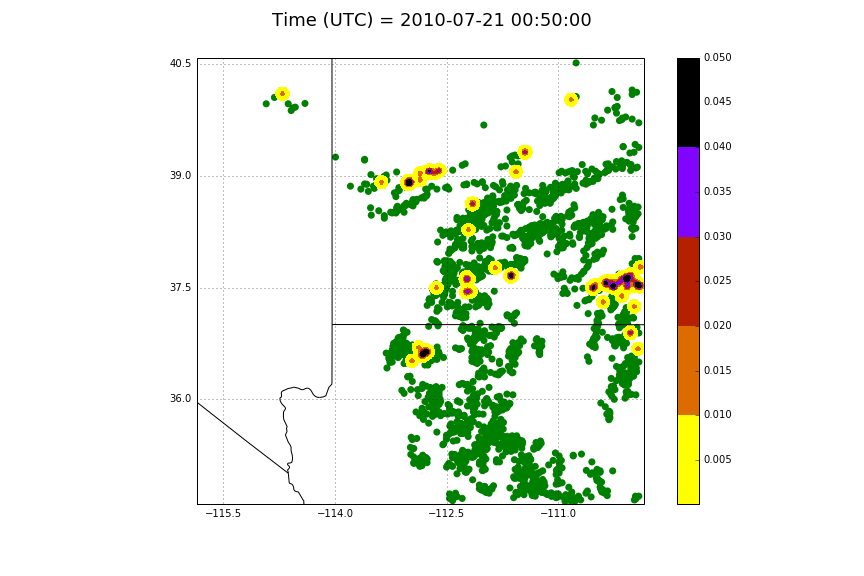
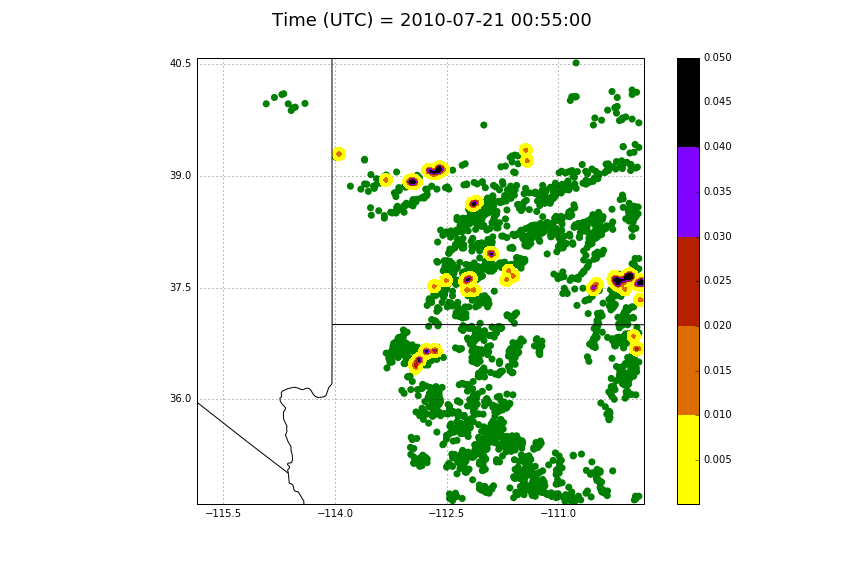
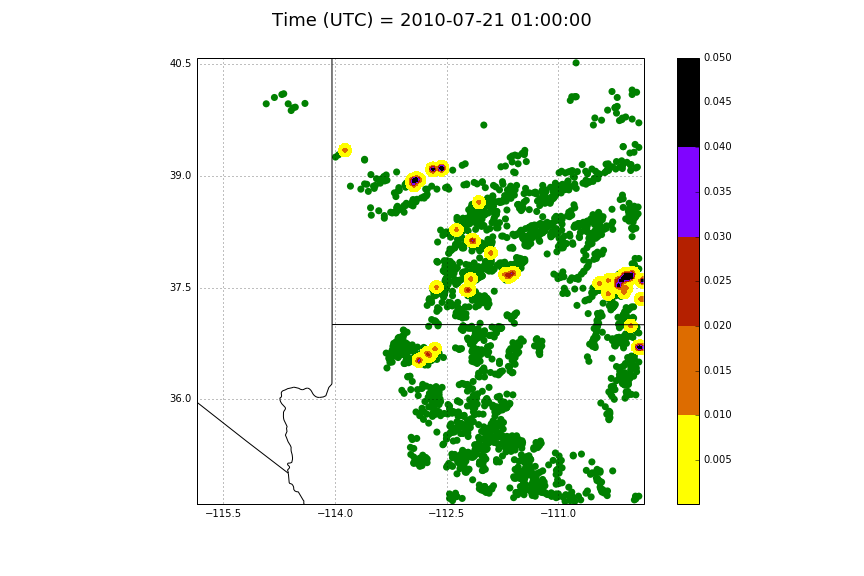
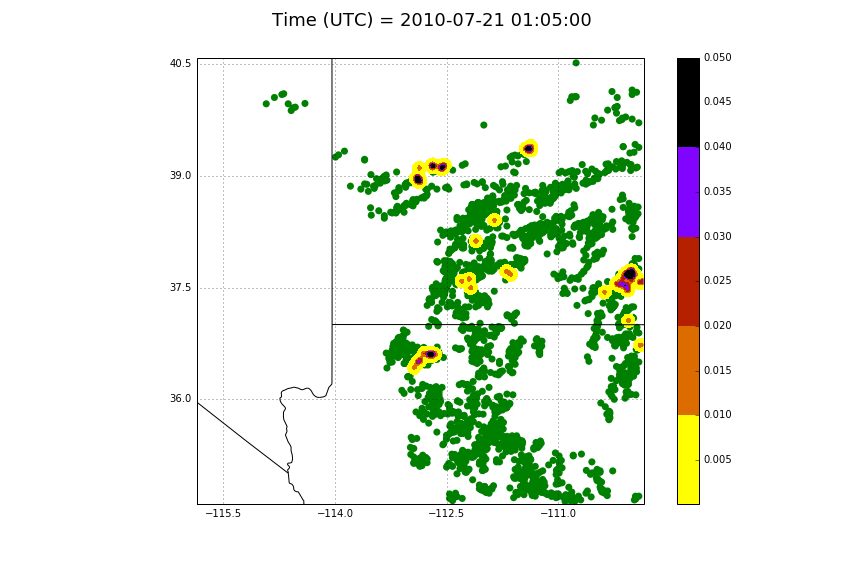
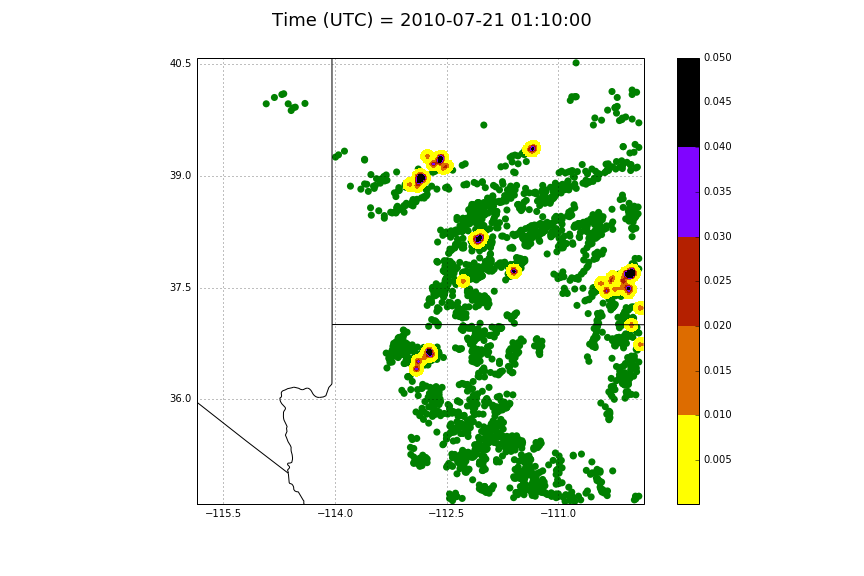
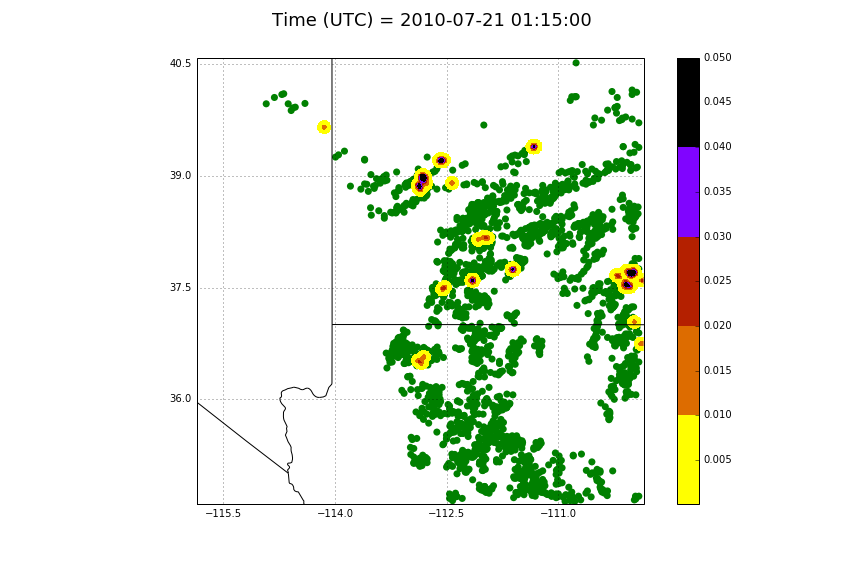
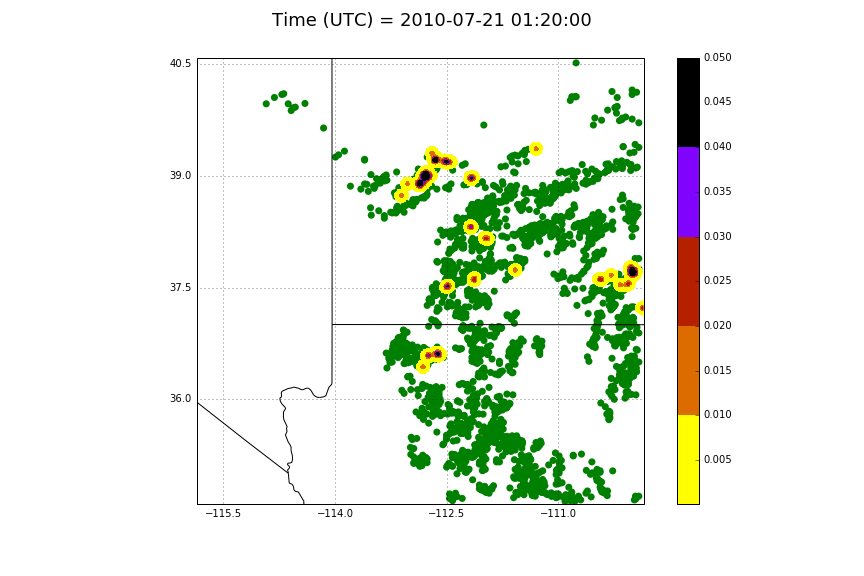
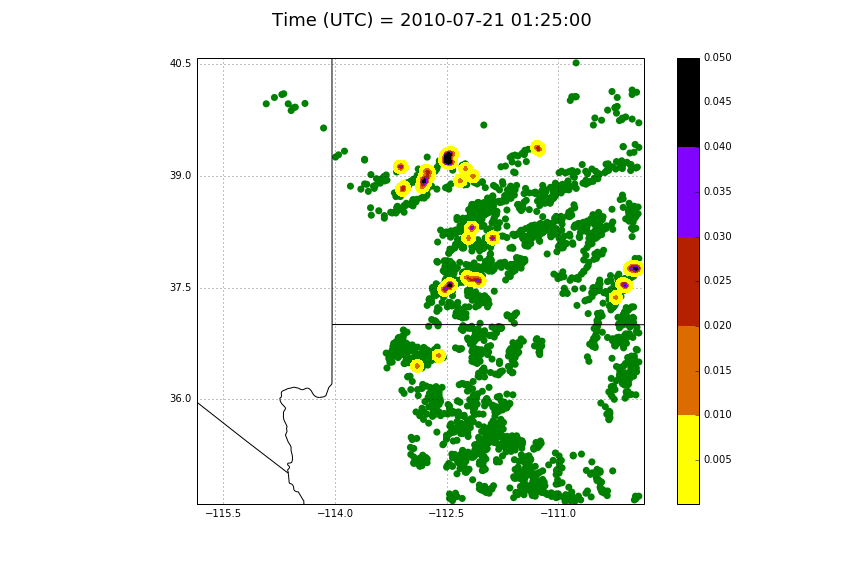
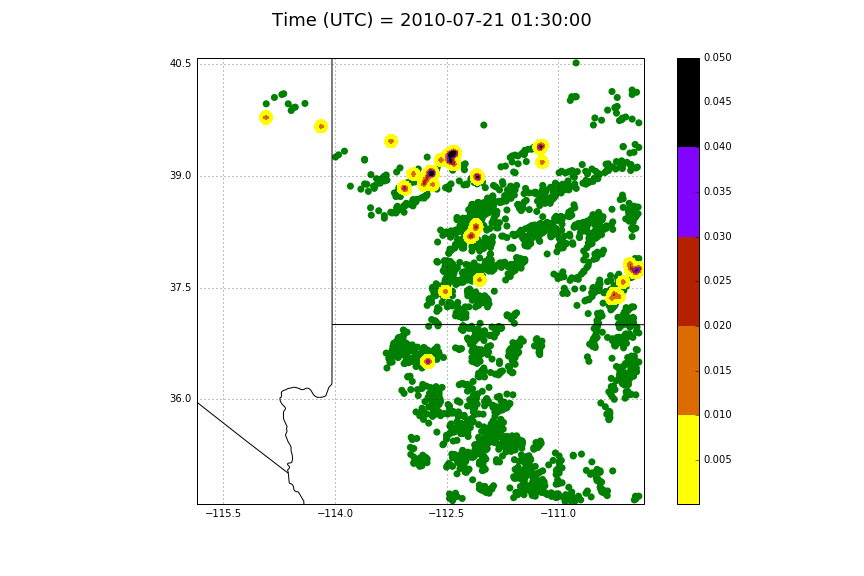
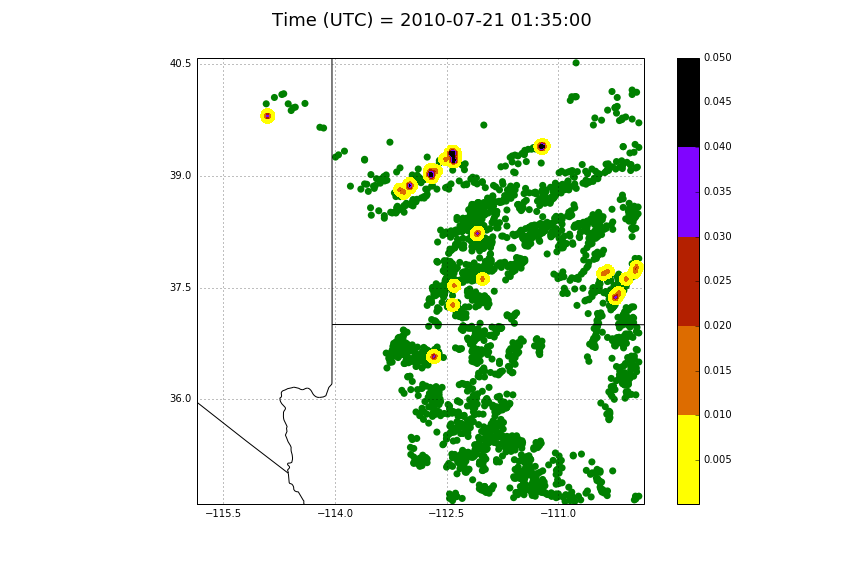
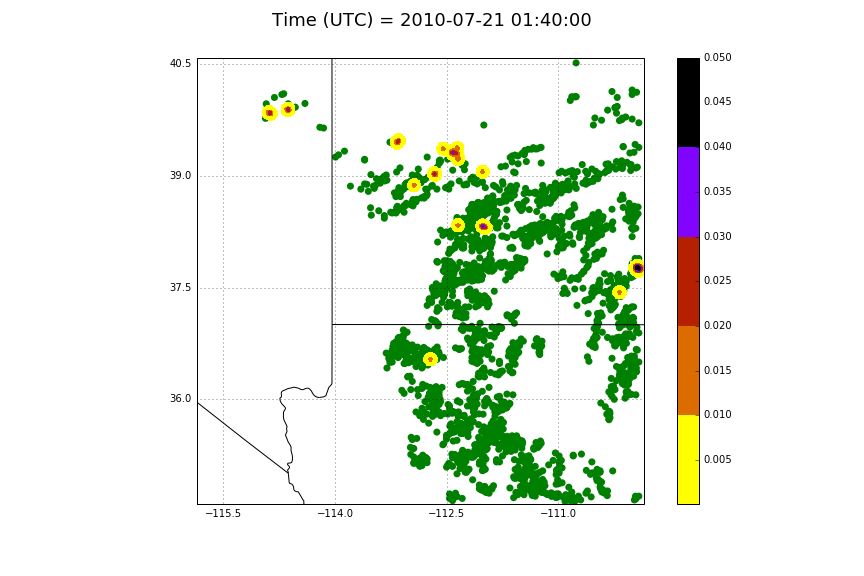
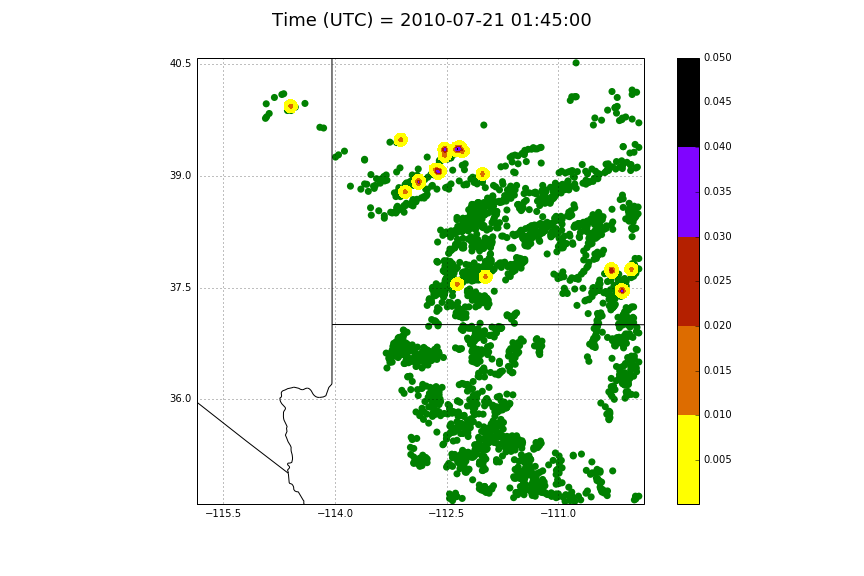
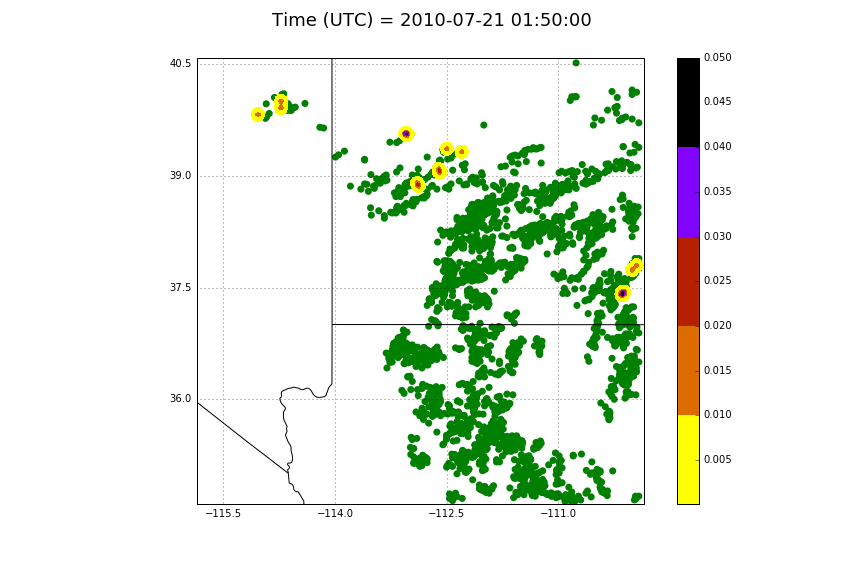
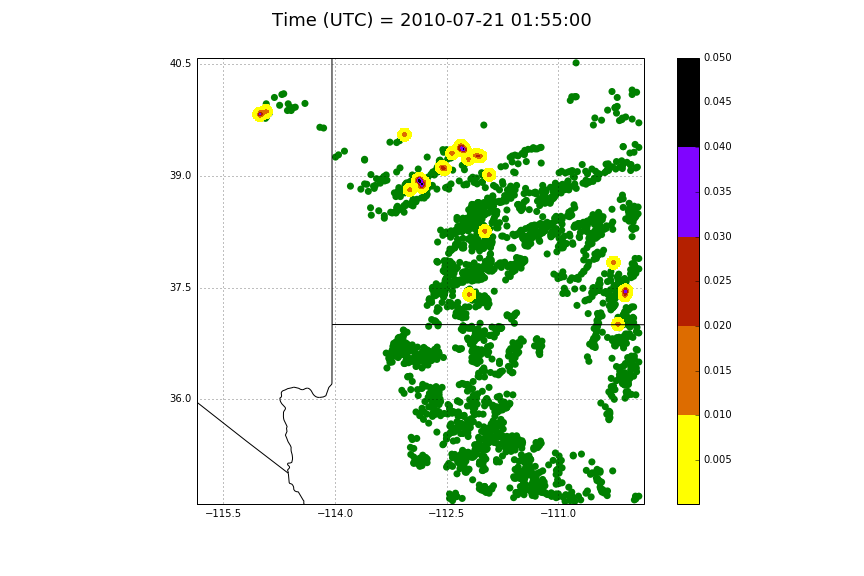
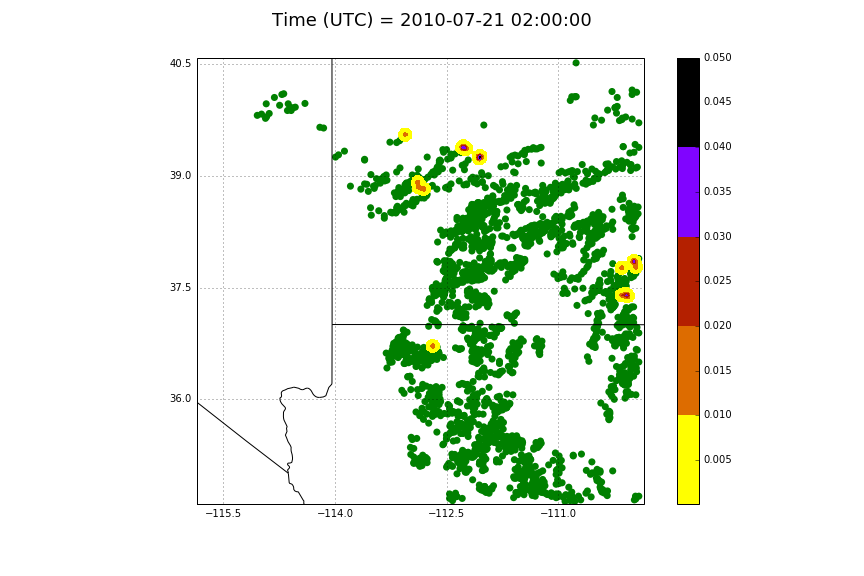
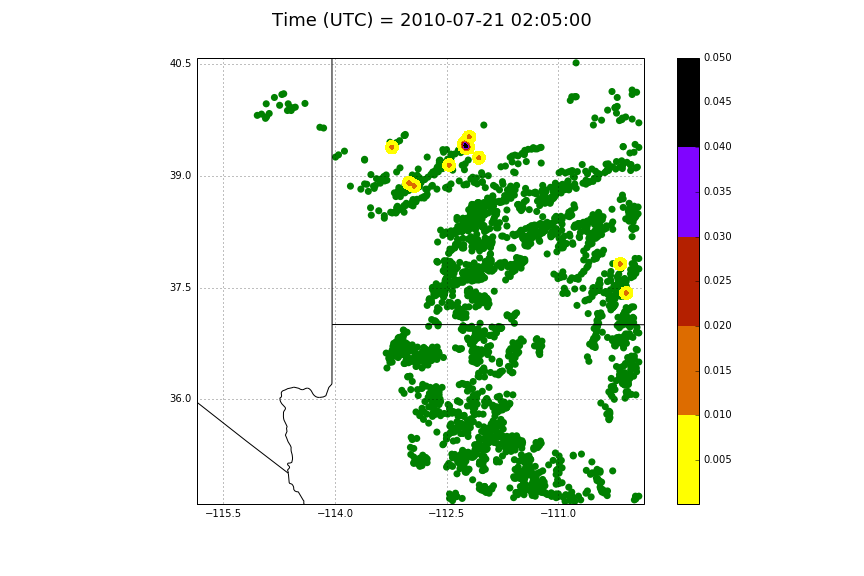
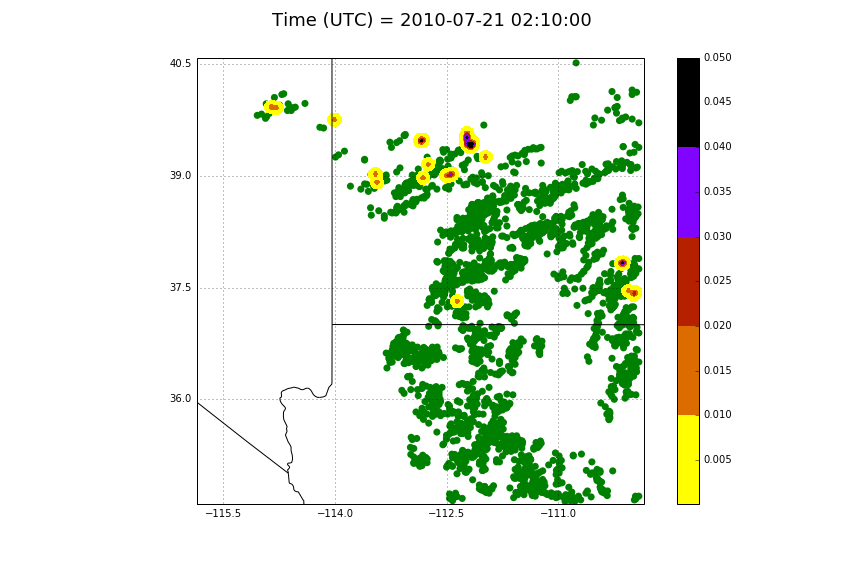
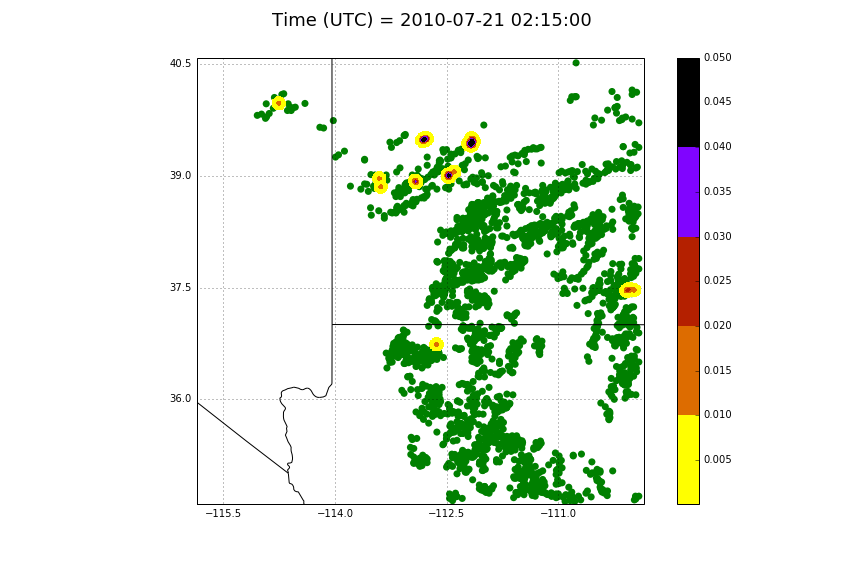

In [6]:
from scipy.ndimage.filters import gaussian_filter
from matplotlib import animation
from JSAnimation import IPython_display

cmap = cmap=plt.get_cmap('gnuplot_r', 5)
cmap.set_under('None')
gauss2d = np.array([gaussian_filter(box[i,:,:], 3) for i in range(box.shape[0])])

it0 = 72
by = 1
fig = plt.figure(figsize=(12, 8))

ax2 = background(plt.subplot(1, 1, 1, projection=ccrs.PlateCarree()))
im2, ax2 = c.plot_grid(gauss2d[it0], vmin=0.0001, vmax=.05, cmap=cmap, cbar=True, ax=ax2)

def init():
    im2.set_data(gauss2d[it0])
    return im2, 

def animate(i):
    im2.set_data(gauss2d[it0+i*by])
    try:
        ax2.scatter(p[tr[it0+i*by],:,'centroidX'],p[tr[it0+i*by],:,'centroidY'], 
                    c='green', edgecolors='None', s=50)
    except:
        pass
    fig.suptitle("Time (UTC) = {t}".format(t=tr[it0+i*by]), fontsize=18)
    return im2,  

animation.FuncAnimation(fig, animate, init_func=init, blit=False, frames=100, interval=200)

## Conclusion: Lightning data is promising to fill gaps in storm initiation and movement

<h1><center>github.com/jsignell</center></h1>